# compare Run 6 results from Run 13378 with BOT Run 5

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sys
import copy
from matplotlib import pyplot as plt
from matplotlib import lines
from mpl_toolkits import axes_grid1
from astropy.stats import sigma_clip
from scipy.stats import skew
from tabulate import tabulate

import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from lsst.obs.lsst import LsstCam, LsstTS8
import lsst.eo.pipe as eo_pipe
from lsst.eo.pipe import (readNoiseTask, darkCurrentTask, defectsTask,
                          eperTask, divisaderoTearingTask, ptcPlotsTask,
                          linearityPlotsTask, bfAnalysisTask)

from myutils import *





# Get eopipe data for Run 13378 a C sequence

In [2]:
repo = '/repo/ir2'
operator = 'lsstccs'
acq_run = '13378'  # This is a D-protocol run.
weekly = 'w_2023_24'

# We use the collection naming scheme to find all of the chained collections for an eo_pipe analysis of 
# the specified run.  For our dataset queries, we'll use these collections.
butler = daf_butler.Butler(repo)
collections = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
for item in collections:
    print(item)

u/lsstccs/eo_bias_stability_13378_w_2023_24
u/lsstccs/eo_dark_current_13378_w_2023_24
u/lsstccs/eo_raft_calib_mosaics_13378_w_2023_24
u/lsstccs/eo_eper_13378_w_2023_24
u/lsstccs/eo_ptc_plots_13378_w_2023_24
u/lsstccs/eo_cti_vs_flux_13378_w_2023_24
u/lsstccs/eo_raft_lambda_mosaics_13378_w_2023_24
u/lsstccs/eo_bf_analysis_13378_w_2023_24
u/lsstccs/eo_divisadero_tearing_13378_w_2023_24
u/lsstccs/eo_bright_defects_13378_w_2023_24
u/lsstccs/eo_read_noise_13378_w_2023_24
u/lsstccs/eo_dark_defects_13378_w_2023_24
u/lsstccs/eo_raft_amp_correlations_13378_w_2023_24
u/lsstccs/eo_persistence_13378_w_2023_24


In [3]:
# Several eo_pipe pipelines produce per-amp measurements for all of the CCDs in the current Camera object.
# For LSSTCam, this would include all 205 CCDs in the focal plane; for TS8, this would be the 9 CCDs in 
# the raft installed at that test stand (currently RTM-004).
#
# The `eo_pipe.get_amp_data` function will retrieve these per-amp measurements and return them as a 
# three-level dictionary, keyed by measurement quantity, CCD (labeled by R**_S for LSSTCam), and 
# amplifier data (labeled by channel name, e.g., 'C01').
#
# The '[ps]cti' quantities are measured from combined flats, so will have different values depending on the
# filter used, since combined flats a created separately for each filter combination.
amp_data = eo_pipe.get_amp_data(repo, collections)
for quantity in amp_data.keys():
    print(quantity)

read_noise
bright_columns
bright_pixels
dark_columns
dark_pixels
dark_current_95
dark_current_median
divisadero_tearing
ptc_turnoff
ptc_a00
ptc_noise
ptc_gain
row_mean_var_slope
('scti', 'LOW')
('pcti', 'LOW')
('scti', 'HIGH')
('pcti', 'HIGH')
bf_xcorr
bf_ycorr
bf_mean
bf_slope_x
bf_slope_x_err
bf_slope_y
bf_slope_y_err


In [4]:
df_data = eopipe_DictToDfz(amp_data)

{'R21_S21', 'R24_S11', 'R10_S02', 'R24_S21', 'R34_S10', 'R13_S11', 'R11_S10', 'R01_S21', 'R32_S10', 'R12_S20', 'R31_S01', 'R12_S02', 'R04_SG1', 'R10_S11', 'R01_S00', 'R40_SW1', 'R34_S02', 'R14_S21', 'R41_S01', 'R31_S20', 'R10_S21', 'R23_S22', 'R11_S22', 'R22_S20', 'R43_S21', 'R03_S01', 'R24_S00', 'R32_S00', 'R42_S20', 'R30_S21', 'R43_S22', 'R41_S21', 'R14_S10', 'R33_S20', 'R32_S02', 'R23_S20', 'R43_S01', 'R30_S12', 'R21_S11', 'R30_S01', 'R12_S10', 'R03_S11', 'R30_S10', 'R43_S20', 'R41_S10', 'R11_S12', 'R21_S02', 'R14_S11', 'R33_S21', 'R14_S20', 'R21_S12', 'R34_S20', 'R14_S02', 'R22_S21', 'R20_S22', 'R24_S10', 'R22_S22', 'R13_S21', 'R21_S01', 'R23_S00', 'R30_S02', 'R00_SG0', 'R01_S10', 'R10_S01', 'R31_S02', 'R01_S22', 'R31_S21', 'R12_S01', 'R23_S21', 'R12_S22', 'R40_SG1', 'R11_S00', 'R04_SW0', 'R41_S12', 'R02_S21', 'R20_S21', 'R13_S10', 'R10_S00', 'R02_S00', 'R23_S02', 'R20_S10', 'R13_S20', 'R41_S02', 'R03_S10', 'R41_S11', 'R32_S12', 'R31_S11', 'R21_S10', 'R33_S01', 'R02_S11', 'R40_SG0'

In [5]:
print(df_data.columns)

Index(['READ_NOISE', 'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS',
       'DARK_PIXELS', 'DARK_CURRENT_95', 'DARK_CURRENT_MEDIAN',
       'DIVISADERO_TEARING', 'PTC_TURNOFF', 'PTC_A00', 'PTC_NOISE', 'PTC_GAIN',
       'ROW_MEAN_VAR_SLOPE', 'BF_XCORR', 'BF_YCORR', 'BF_MEAN', 'BF_SLOPE_X',
       'BF_SLOPE_X_ERR', 'BF_SLOPE_Y', 'BF_SLOPE_Y_ERR', 'SCTI_LOW',
       'PCTI_LOW', 'SCTI_HIGH', 'PCTI_HIGH', 'BAY', 'SLOT', 'AMP', 'BAYTYPE',
       'BAY_SLOT', 'SEGMENT'],
      dtype='object')


## Run 5 data from 13162 and 13144

In [6]:
df_run5 = pd.read_parquet('df_13144_13162_w_2023_22.parquet')
print(df_run5.columns)


Index(['READ_NOISE', 'DARK_CURRENT_95', 'DARK_CURRENT_MEDIAN',
       'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS', 'DARK_PIXELS',
       'DIVISADERO_TEARING', 'PTC_NOISE', 'PTC_A00', 'PTC_TURNOFF', 'PTC_GAIN',
       'ROW_MEAN_VAR_SLOPE', 'MAX_FRAC_DEV', 'MAX_OBSERVED_SIGNAL',
       'LINEARITY_TURNOFF', 'BF_XCORR', 'BF_YCORR', 'BF_MEAN', 'BF_SLOPE_X',
       'BF_SLOPE_X_ERR', 'BF_SLOPE_Y', 'BF_SLOPE_Y_ERR', 'SCTI_LOW',
       'PCTI_LOW', 'SCTI_HIGH', 'PCTI_HIGH', 'BAY', 'SLOT', 'AMP', 'BAYTYPE',
       'BAY_SLOT', 'SEGMENT'],
      dtype='object')


In [7]:
# merge the DataFrames
df_merge1 = df_data.merge(df_run5,how='outer',on=['BAY_SLOT','SEGMENT','BAY','SLOT','AMP','BAYTYPE'],suffixes=('','_RUN5'))

In [9]:
# variables with XX and XX_RUN5 are in both DataFrames 
print(df_merge1.columns)

Index(['READ_NOISE', 'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS',
       'DARK_PIXELS', 'DARK_CURRENT_95', 'DARK_CURRENT_MEDIAN',
       'DIVISADERO_TEARING', 'PTC_TURNOFF', 'PTC_A00', 'PTC_NOISE', 'PTC_GAIN',
       'ROW_MEAN_VAR_SLOPE', 'BF_XCORR', 'BF_YCORR', 'BF_MEAN', 'BF_SLOPE_X',
       'BF_SLOPE_X_ERR', 'BF_SLOPE_Y', 'BF_SLOPE_Y_ERR', 'SCTI_LOW',
       'PCTI_LOW', 'SCTI_HIGH', 'PCTI_HIGH', 'BAY', 'SLOT', 'AMP', 'BAYTYPE',
       'BAY_SLOT', 'SEGMENT', 'READ_NOISE_RUN5', 'DARK_CURRENT_95_RUN5',
       'DARK_CURRENT_MEDIAN_RUN5', 'BRIGHT_COLUMNS_RUN5', 'BRIGHT_PIXELS_RUN5',
       'DARK_COLUMNS_RUN5', 'DARK_PIXELS_RUN5', 'DIVISADERO_TEARING_RUN5',
       'PTC_NOISE_RUN5', 'PTC_A00_RUN5', 'PTC_TURNOFF_RUN5', 'PTC_GAIN_RUN5',
       'ROW_MEAN_VAR_SLOPE_RUN5', 'MAX_FRAC_DEV', 'MAX_OBSERVED_SIGNAL',
       'LINEARITY_TURNOFF', 'BF_XCORR_RUN5', 'BF_YCORR_RUN5', 'BF_MEAN_RUN5',
       'BF_SLOPE_X_RUN5', 'BF_SLOPE_X_ERR_RUN5', 'BF_SLOPE_Y_RUN5',
       'BF_SLOPE_Y_ERR_RUN5', 'SCT

In [10]:
## Get list of known problem channels
def mkdf_badchannels():
    
    baddict = {}
    baddict['R30_S00_C10'] = 'Dead Channel'
    baddict['R03_S11_C00'] = 'Dead Channel'
    baddict['R04_SG0_C11'] = 'Dead Channel'
    baddict['R40_SG1_C10'] = 'High Read Noise'
    baddict['R44_SG0_C02'] = 'High Read Noise'
    baddict['R41_S21_C02'] = 'High Read Noise'
    baddict['R43_S20_C14'] = 'High Read Noise'
    baddict['R01_S02_C07'] = 'High Read Noise'
    baddict['R01_S10_C11'] = 'Bright Defect'
    baddict['R01_S00_C14'] = 'Bright Defect'
    baddict['R01_S01_C00'] = 'Formerly Dead, Alive in Run5'
    baddict['R10_S00_C00'] = 'Formerly Dead, Alive in Run5'


    comments = []
    allbayslot = []
    allsegment = []  # Cxx 
    for i, det in enumerate(camera):
        bayslot = det.getName()
        segments = det.getAmplifiers()
        for j,seg in enumerate(segments):
            fullname = bayslot+"_"+seg.getName()
        
            allbayslot.append(bayslot)
            allsegment.append(seg.getName())
            if fullname in baddict:
                comments.append(baddict[fullname])
            else:
                comments.append('Ok')
    
    # output dictionary
    cdf = {}
            
    # add to DF with ccd info
    cdf['BAY_SLOT'] = allbayslot
    cdf['SEGMENT'] = allsegment
    cdf['COMMENT'] = comments
                    
    # fill 
    df = pd.DataFrame(cdf)
    df.columns = df.columns.str.upper()
    return df

In [11]:
df_comment = mkdf_badchannels()

In [12]:
df_merge = df_merge1.merge(df_comment,how='outer',on=['BAY_SLOT','SEGMENT'],suffixes=('','_COMMENT'))

In [13]:
print(df_merge.columns)

Index(['READ_NOISE', 'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS',
       'DARK_PIXELS', 'DARK_CURRENT_95', 'DARK_CURRENT_MEDIAN',
       'DIVISADERO_TEARING', 'PTC_TURNOFF', 'PTC_A00', 'PTC_NOISE', 'PTC_GAIN',
       'ROW_MEAN_VAR_SLOPE', 'BF_XCORR', 'BF_YCORR', 'BF_MEAN', 'BF_SLOPE_X',
       'BF_SLOPE_X_ERR', 'BF_SLOPE_Y', 'BF_SLOPE_Y_ERR', 'SCTI_LOW',
       'PCTI_LOW', 'SCTI_HIGH', 'PCTI_HIGH', 'BAY', 'SLOT', 'AMP', 'BAYTYPE',
       'BAY_SLOT', 'SEGMENT', 'READ_NOISE_RUN5', 'DARK_CURRENT_95_RUN5',
       'DARK_CURRENT_MEDIAN_RUN5', 'BRIGHT_COLUMNS_RUN5', 'BRIGHT_PIXELS_RUN5',
       'DARK_COLUMNS_RUN5', 'DARK_PIXELS_RUN5', 'DIVISADERO_TEARING_RUN5',
       'PTC_NOISE_RUN5', 'PTC_A00_RUN5', 'PTC_TURNOFF_RUN5', 'PTC_GAIN_RUN5',
       'ROW_MEAN_VAR_SLOPE_RUN5', 'MAX_FRAC_DEV', 'MAX_OBSERVED_SIGNAL',
       'LINEARITY_TURNOFF', 'BF_XCORR_RUN5', 'BF_YCORR_RUN5', 'BF_MEAN_RUN5',
       'BF_SLOPE_X_RUN5', 'BF_SLOPE_X_ERR_RUN5', 'BF_SLOPE_Y_RUN5',
       'BF_SLOPE_Y_ERR_RUN5', 'SCT

# Comparison histograms

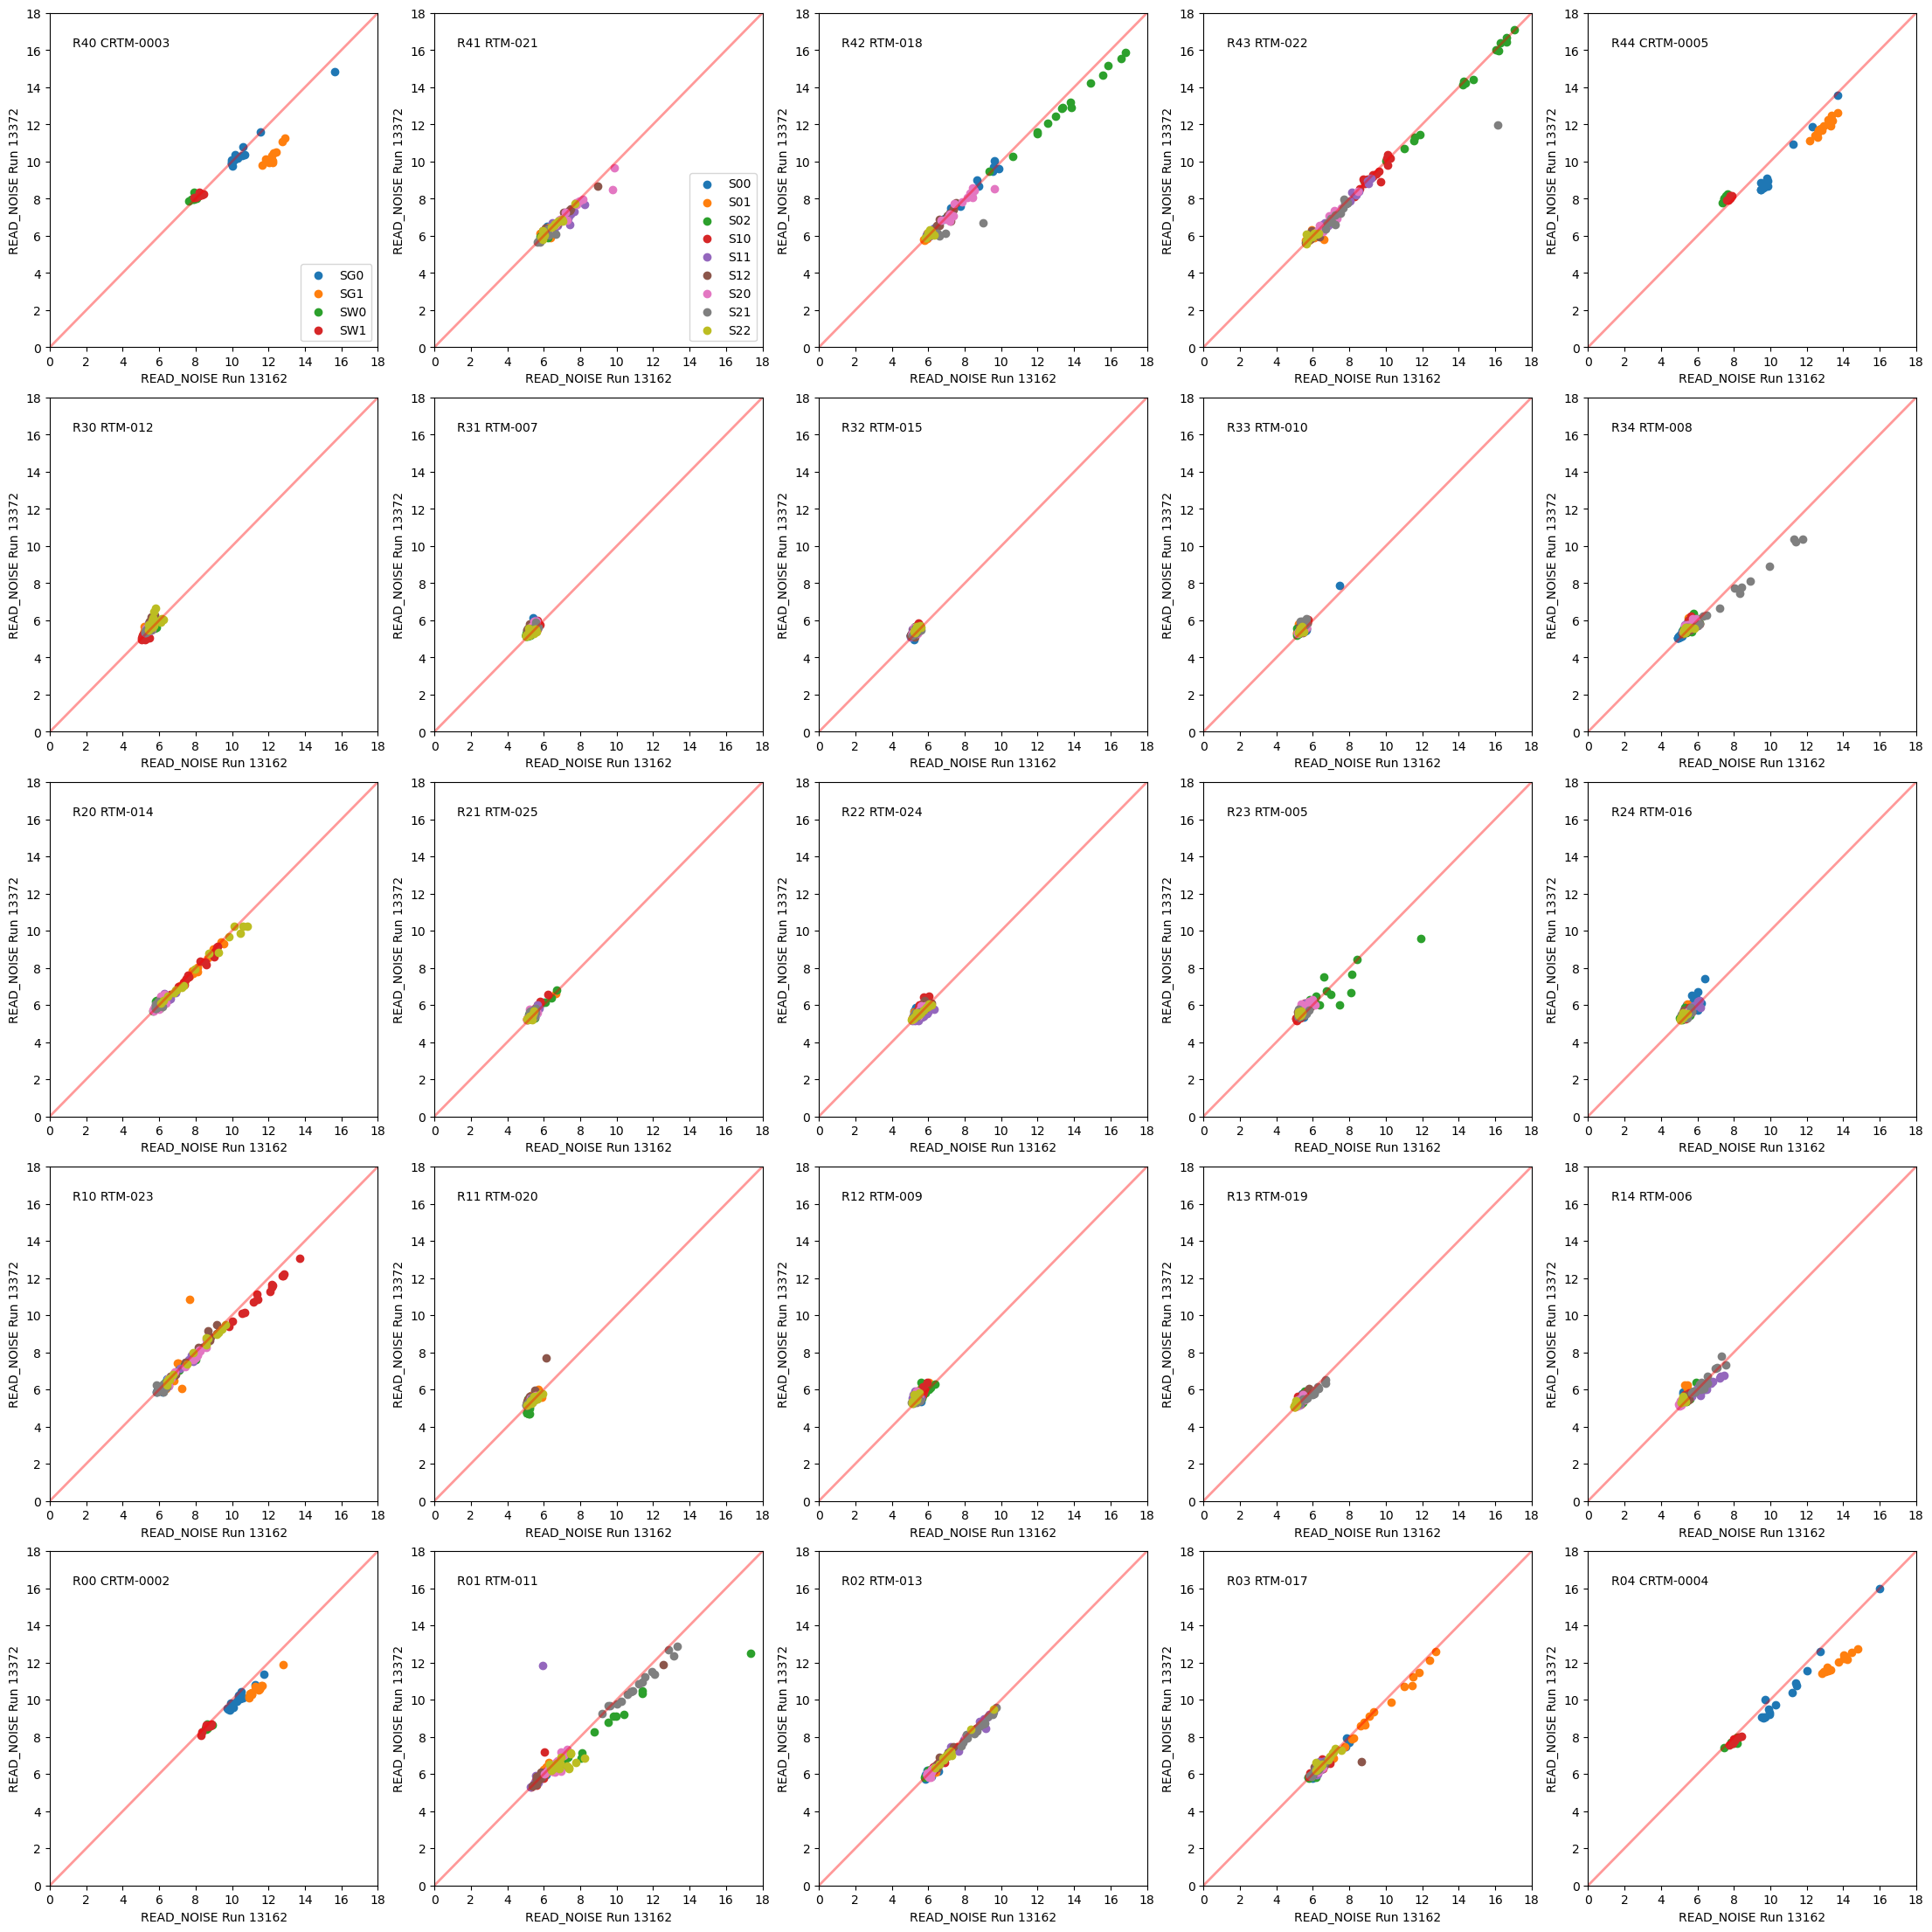

In [14]:
compare_tworuns(df_run5,df_data,'13162','13372',quantity='READ_NOISE',minxy=0.0,maxxy=18.0,save='read_noise_%s'%(acq_run))

## High Noise channels

In [15]:
highnoise = (df_merge.READ_NOISE>18.0)
print(tabulate(df_merge[highnoise][['BAY_SLOT','SEGMENT','READ_NOISE','PTC_GAIN','READ_NOISE_RUN5','PTC_GAIN_RUN5','COMMENT']],headers='keys',tablefmt='psql'))

+------+------------+-----------+--------------+------------+-------------------+-----------------+------------------------------+
|      | BAY_SLOT   | SEGMENT   |   READ_NOISE |   PTC_GAIN |   READ_NOISE_RUN5 |   PTC_GAIN_RUN5 | COMMENT                      |
|------+------------+-----------+--------------+------------+-------------------+-----------------+------------------------------|
|   79 | R01_S01    | C00       |      30.8132 |   10.3554  |           6.17579 |        1.66522  | Formerly Dead, Alive in Run5 |
|  415 | R03_S11    | C00       |      34.0255 |   11.8786  |          42.1017  |       14.6135   | Dead Channel                 |
| 2861 | R41_S21    | C02       |      74.3346 |    1.31834 |         107.984   |        1.20952  | High Read Noise              |
| 3181 | R44_SG0    | C02       |      48.4043 |    1.09048 |          41       |        0.938564 | High Read Noise              |
+------+------------+-----------+--------------+------------+-------------------+--

In [23]:
lownoise = (df_merge.READ_NOISE<4.5)
print(tabulate(df_merge[lownoise][['BAY_SLOT','SEGMENT','READ_NOISE','READ_NOISE_RUN5','COMMENT']],headers='keys',tablefmt='psql'))

+------------+-----------+--------------+-------------------+-----------+
| BAY_SLOT   | SEGMENT   | READ_NOISE   | READ_NOISE_RUN5   | COMMENT   |
|------------+-----------+--------------+-------------------+-----------|
+------------+-----------+--------------+-------------------+-----------+


# PTC Gain

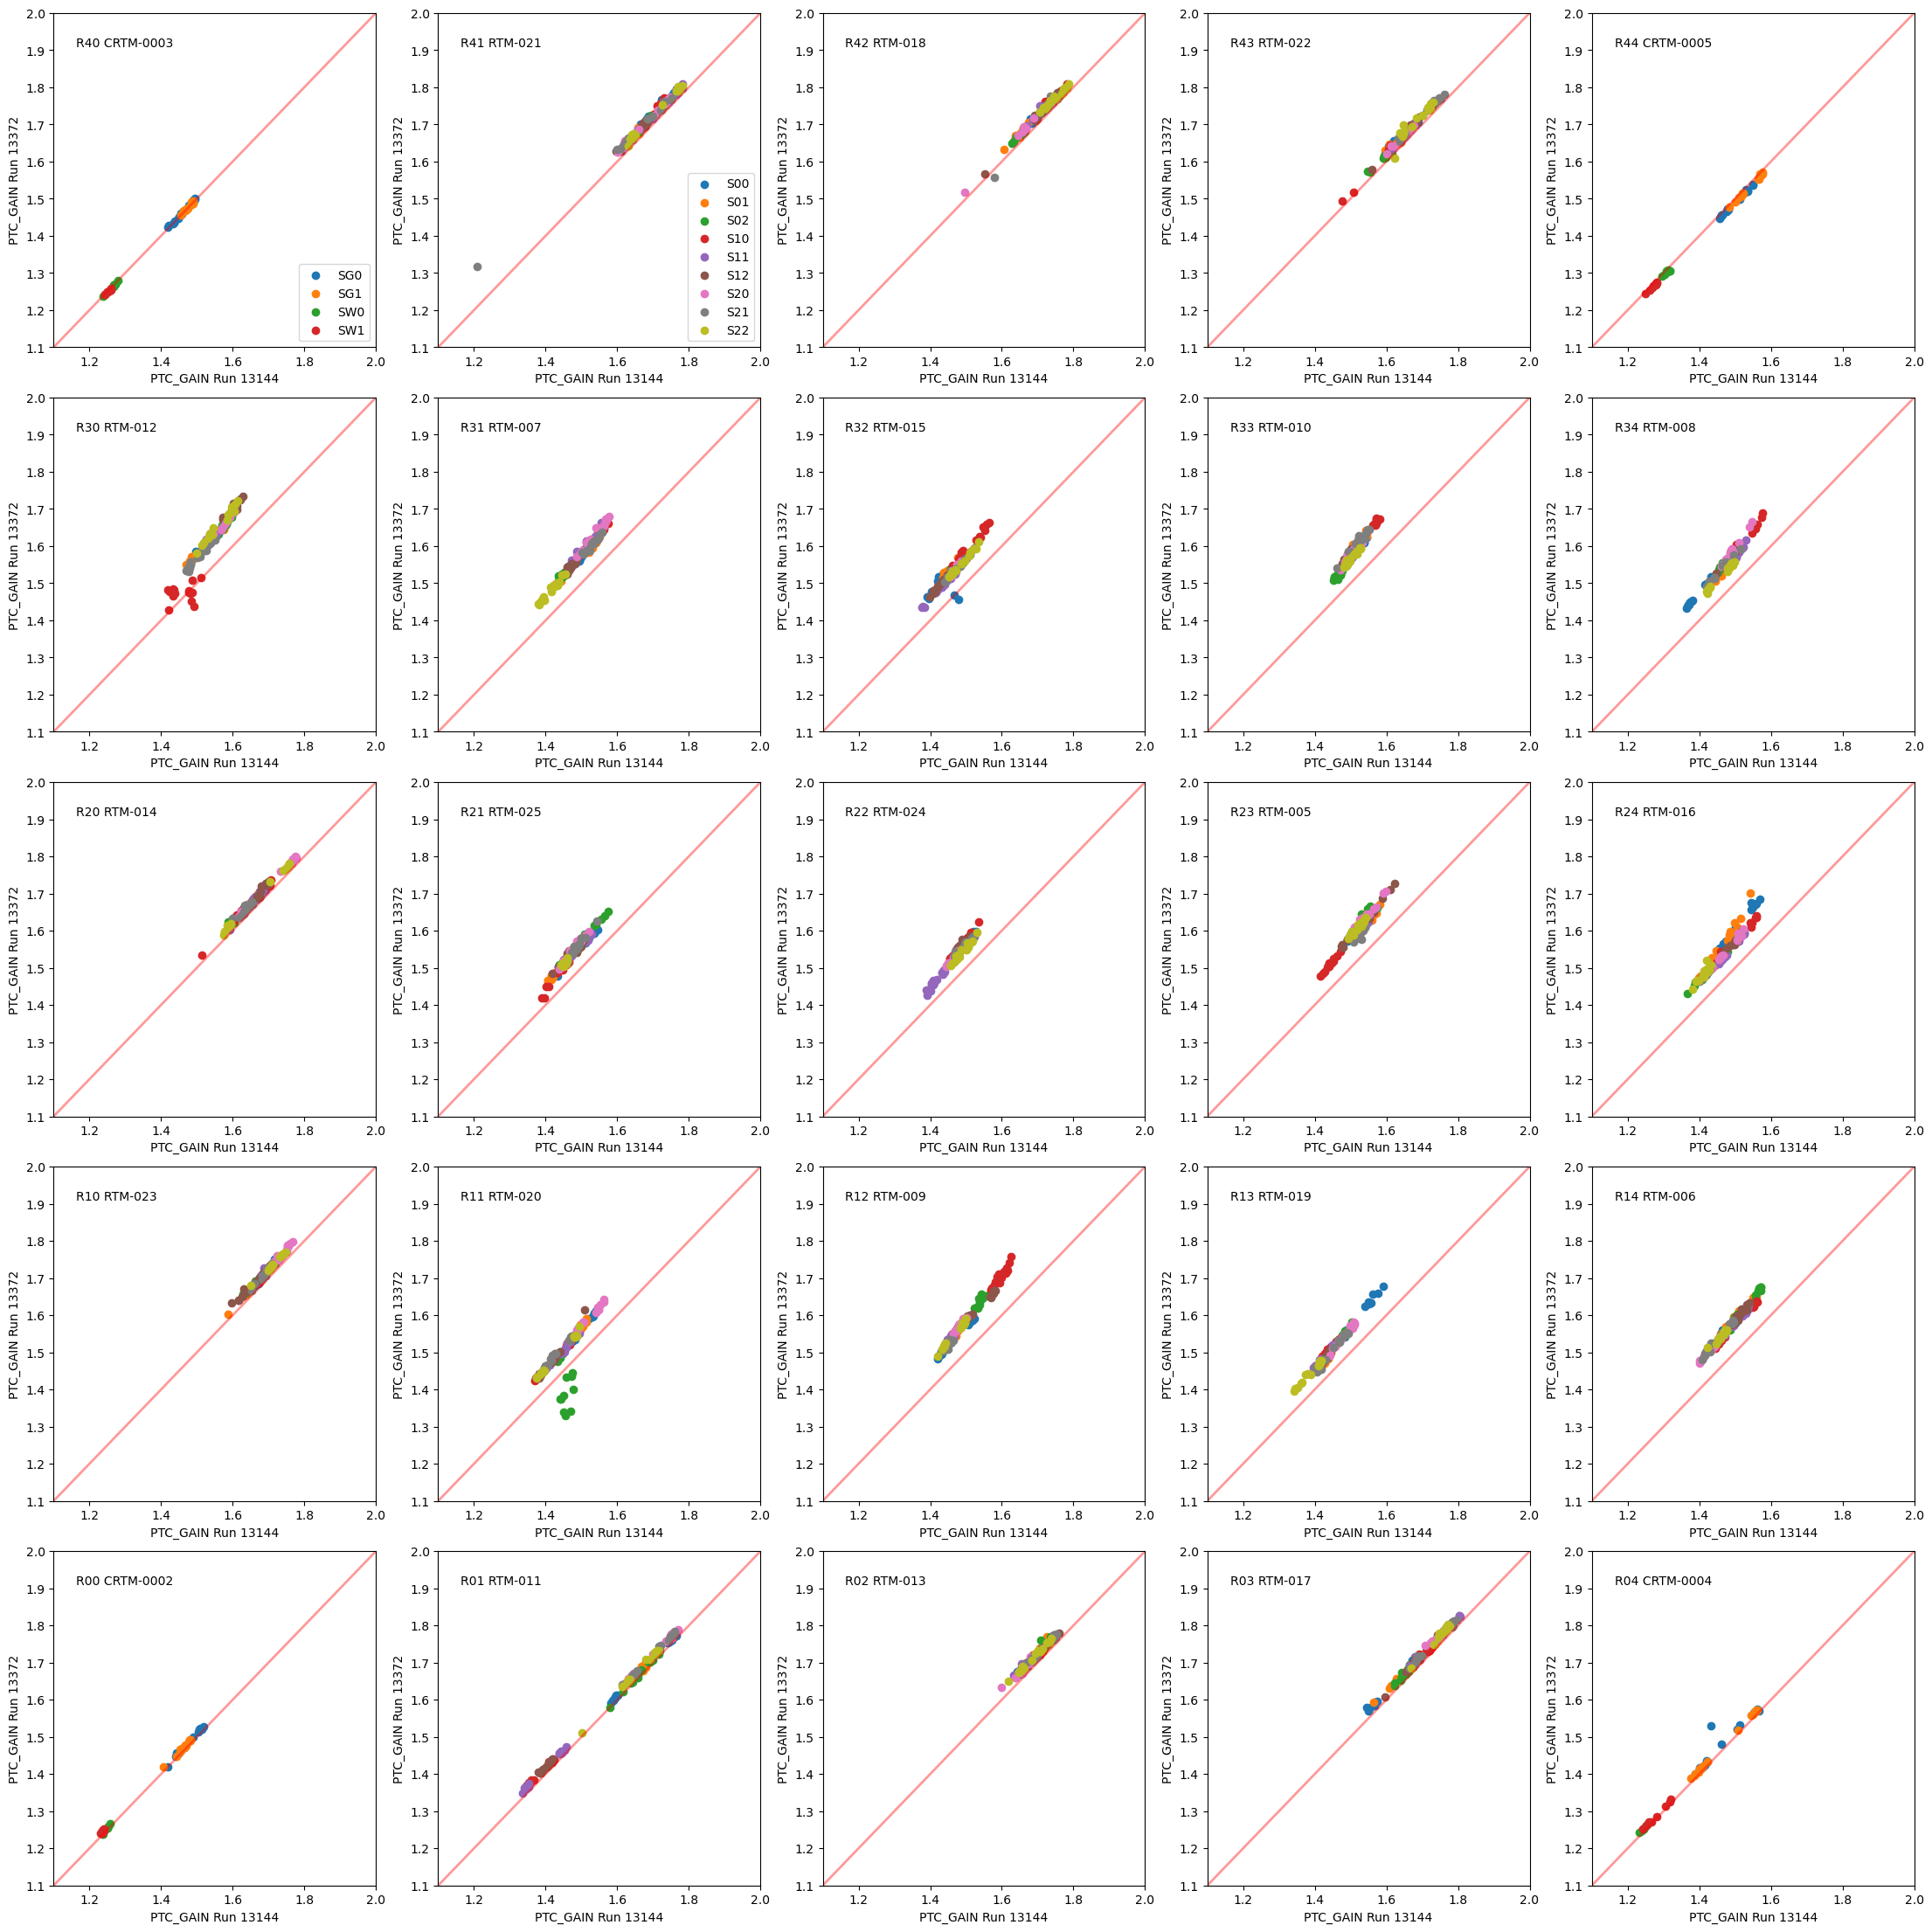

In [24]:
compare_tworuns(df_run5,df_data,'13144','13372',quantity='PTC_GAIN',minxy=1.1,maxxy=2.0,save='ptc_gain_%s.png'%(acq_run))

In [25]:
badgain = (df_merge.PTC_GAIN>2.0) | (df_merge.PTC_GAIN<1.2) | (np.isnan(df_merge.PTC_GAIN))
highnoise = (df_merge.READ_NOISE>18.0)
print(tabulate(df_merge[badgain][['BAY_SLOT','SEGMENT','READ_NOISE','PTC_GAIN','READ_NOISE_RUN5','PTC_GAIN_RUN5','COMMENT']],headers='keys',tablefmt='psql'))

+------+------------+-----------+--------------+------------+-------------------+-----------------+------------------------------+
|      | BAY_SLOT   | SEGMENT   |   READ_NOISE |   PTC_GAIN |   READ_NOISE_RUN5 |   PTC_GAIN_RUN5 | COMMENT                      |
|------+------------+-----------+--------------+------------+-------------------+-----------------+------------------------------|
|   79 | R01_S01    | C00       |      30.8132 |   10.3554  |           6.17579 |        1.66522  | Formerly Dead, Alive in Run5 |
|  415 | R03_S11    | C00       |      34.0255 |   11.8786  |          42.1017  |       14.6135   | Dead Channel                 |
|  481 | R04_SG0    | C11       |     nan      |  nan       |         nan       |      nan        | Dead Channel                 |
| 1968 | R30_S00    | C10       |     nan      |  nan       |         nan       |      nan        | Dead Channel                 |
| 2704 | R40_SG1    | C10       |     nan      |  nan       |         111.657   |  

# CTI Serial and Parallel

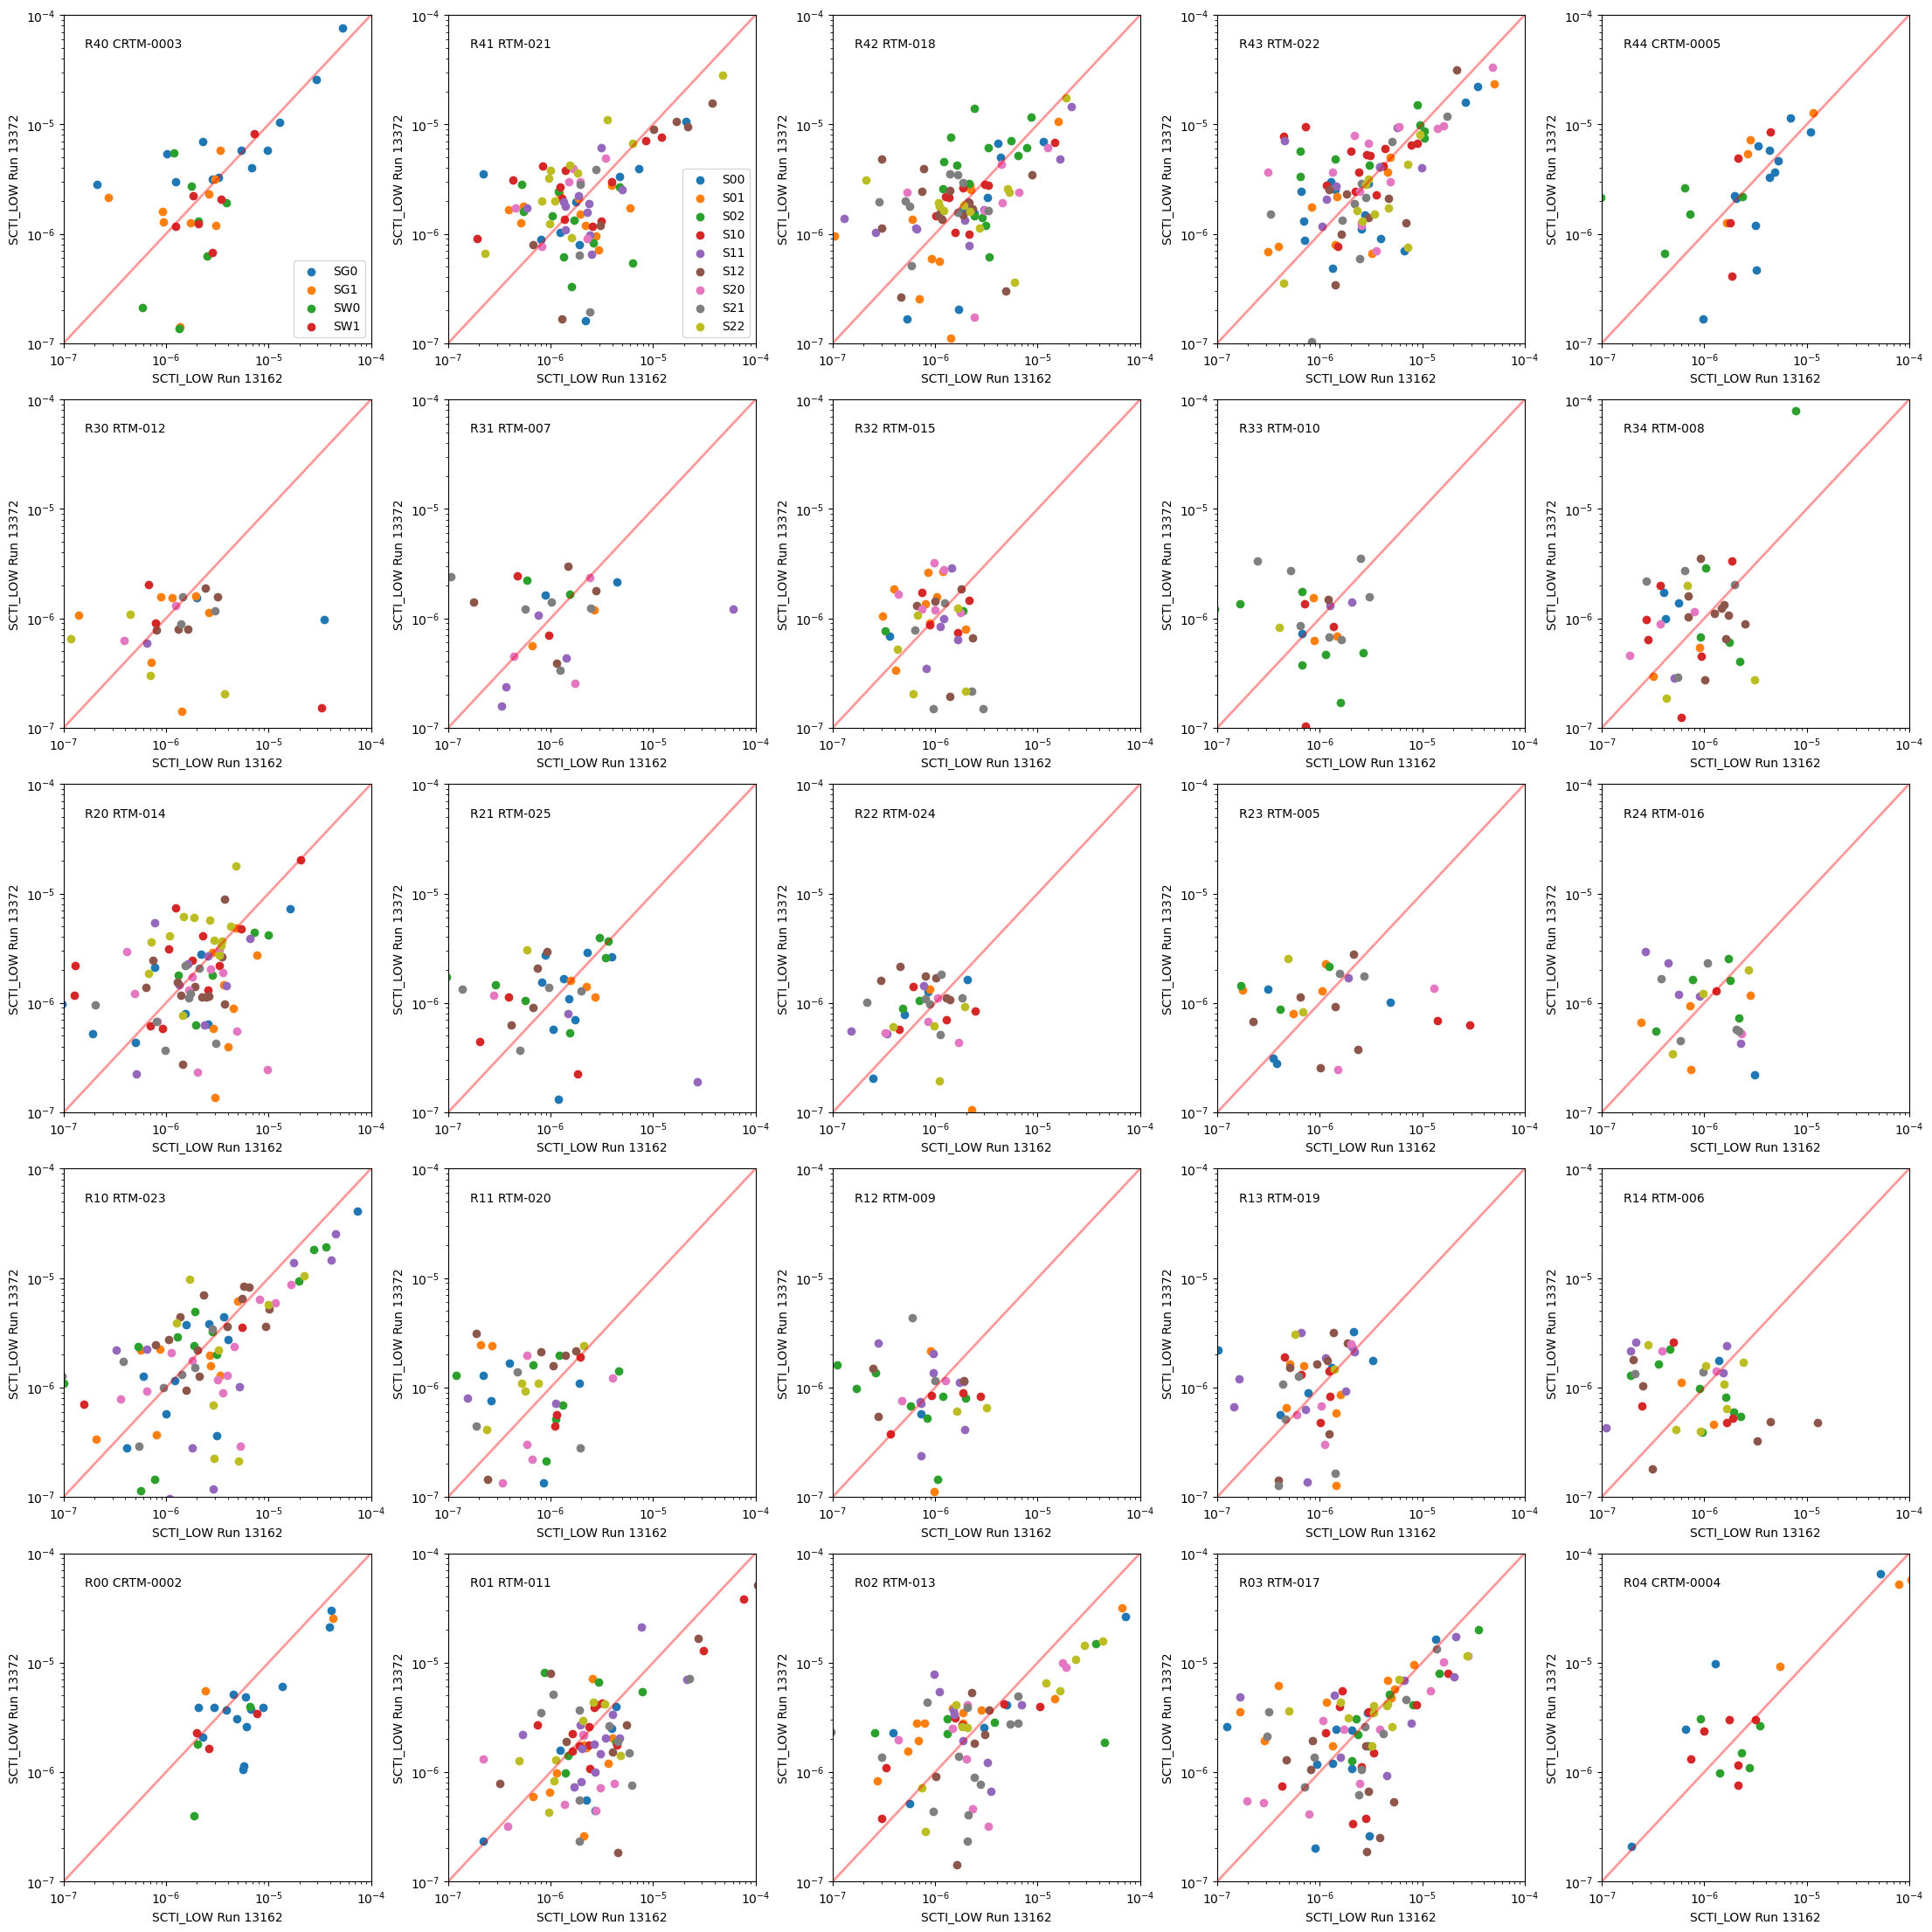

In [26]:
compare_tworuns(df_run5,df_data,'13162','13372',quantity='SCTI_LOW',minxy=1.e-7,maxxy=1.e-4,scale='log',save='scti_low_%s'%(acq_run))

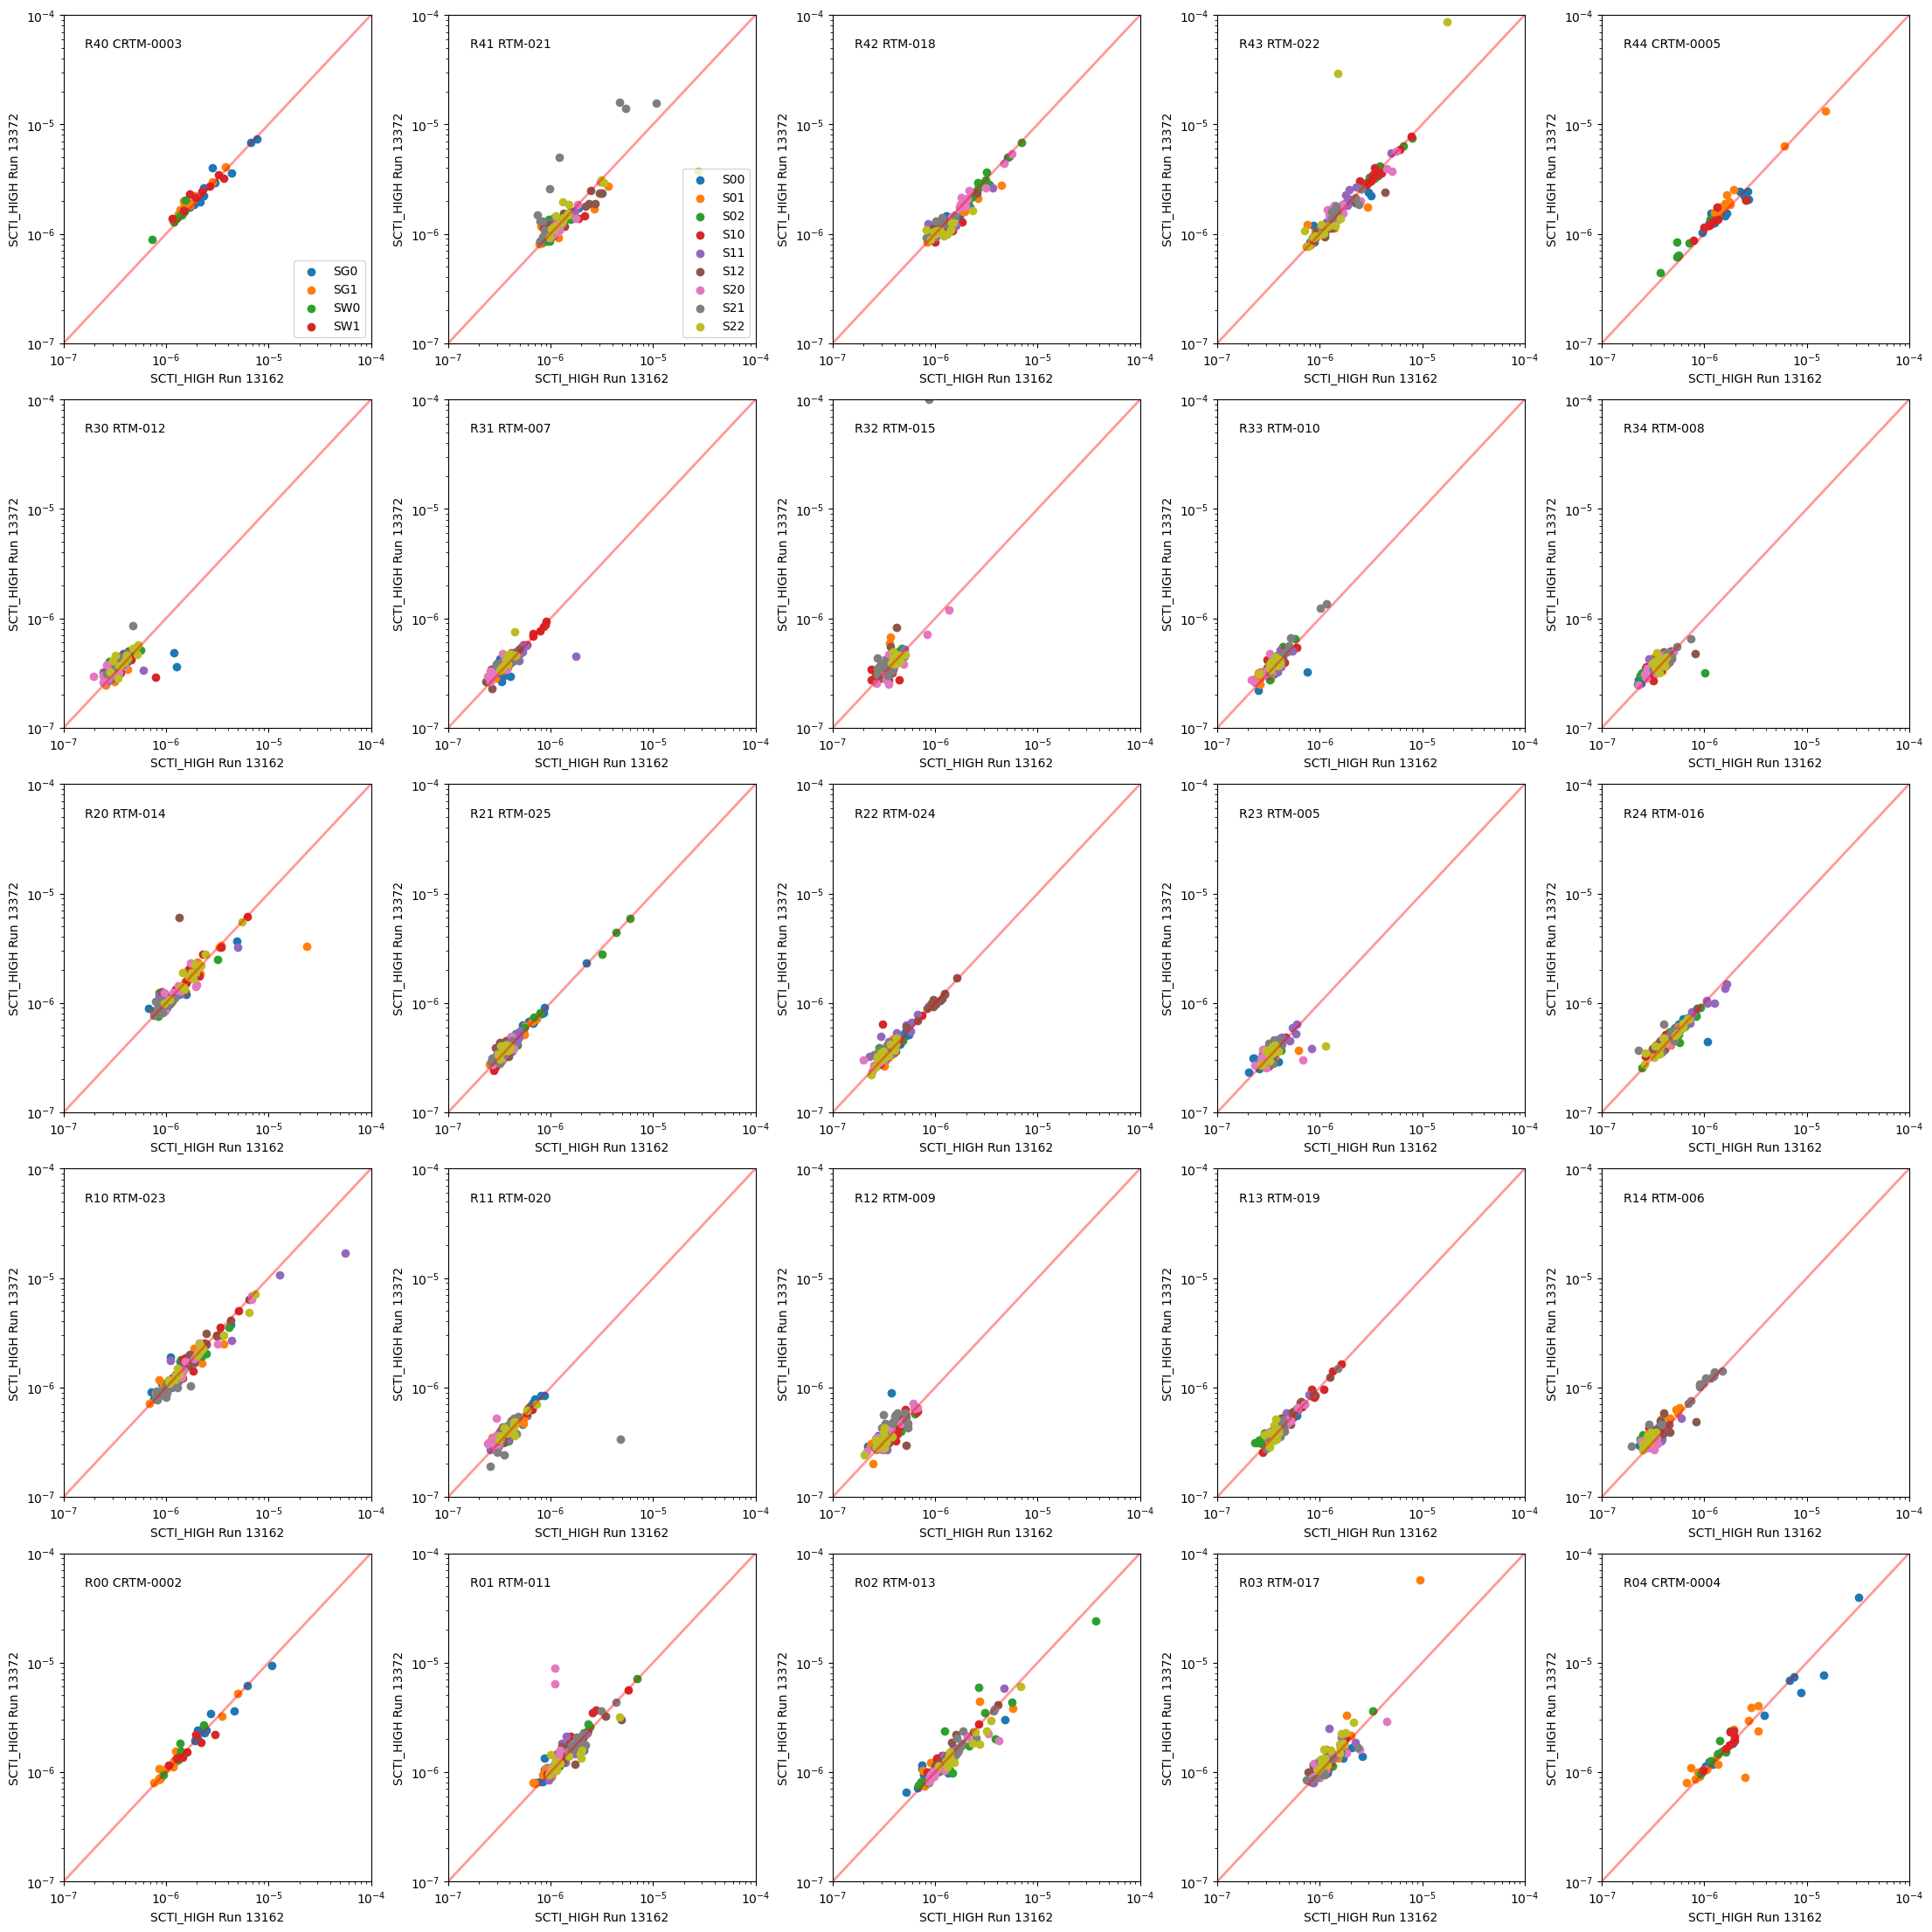

In [27]:
compare_tworuns(df_run5,df_data,'13162','13372',quantity='SCTI_HIGH',minxy=1.e-7,maxxy=1.e-4,scale='log',save='scti_high_%s'%(acq_run))

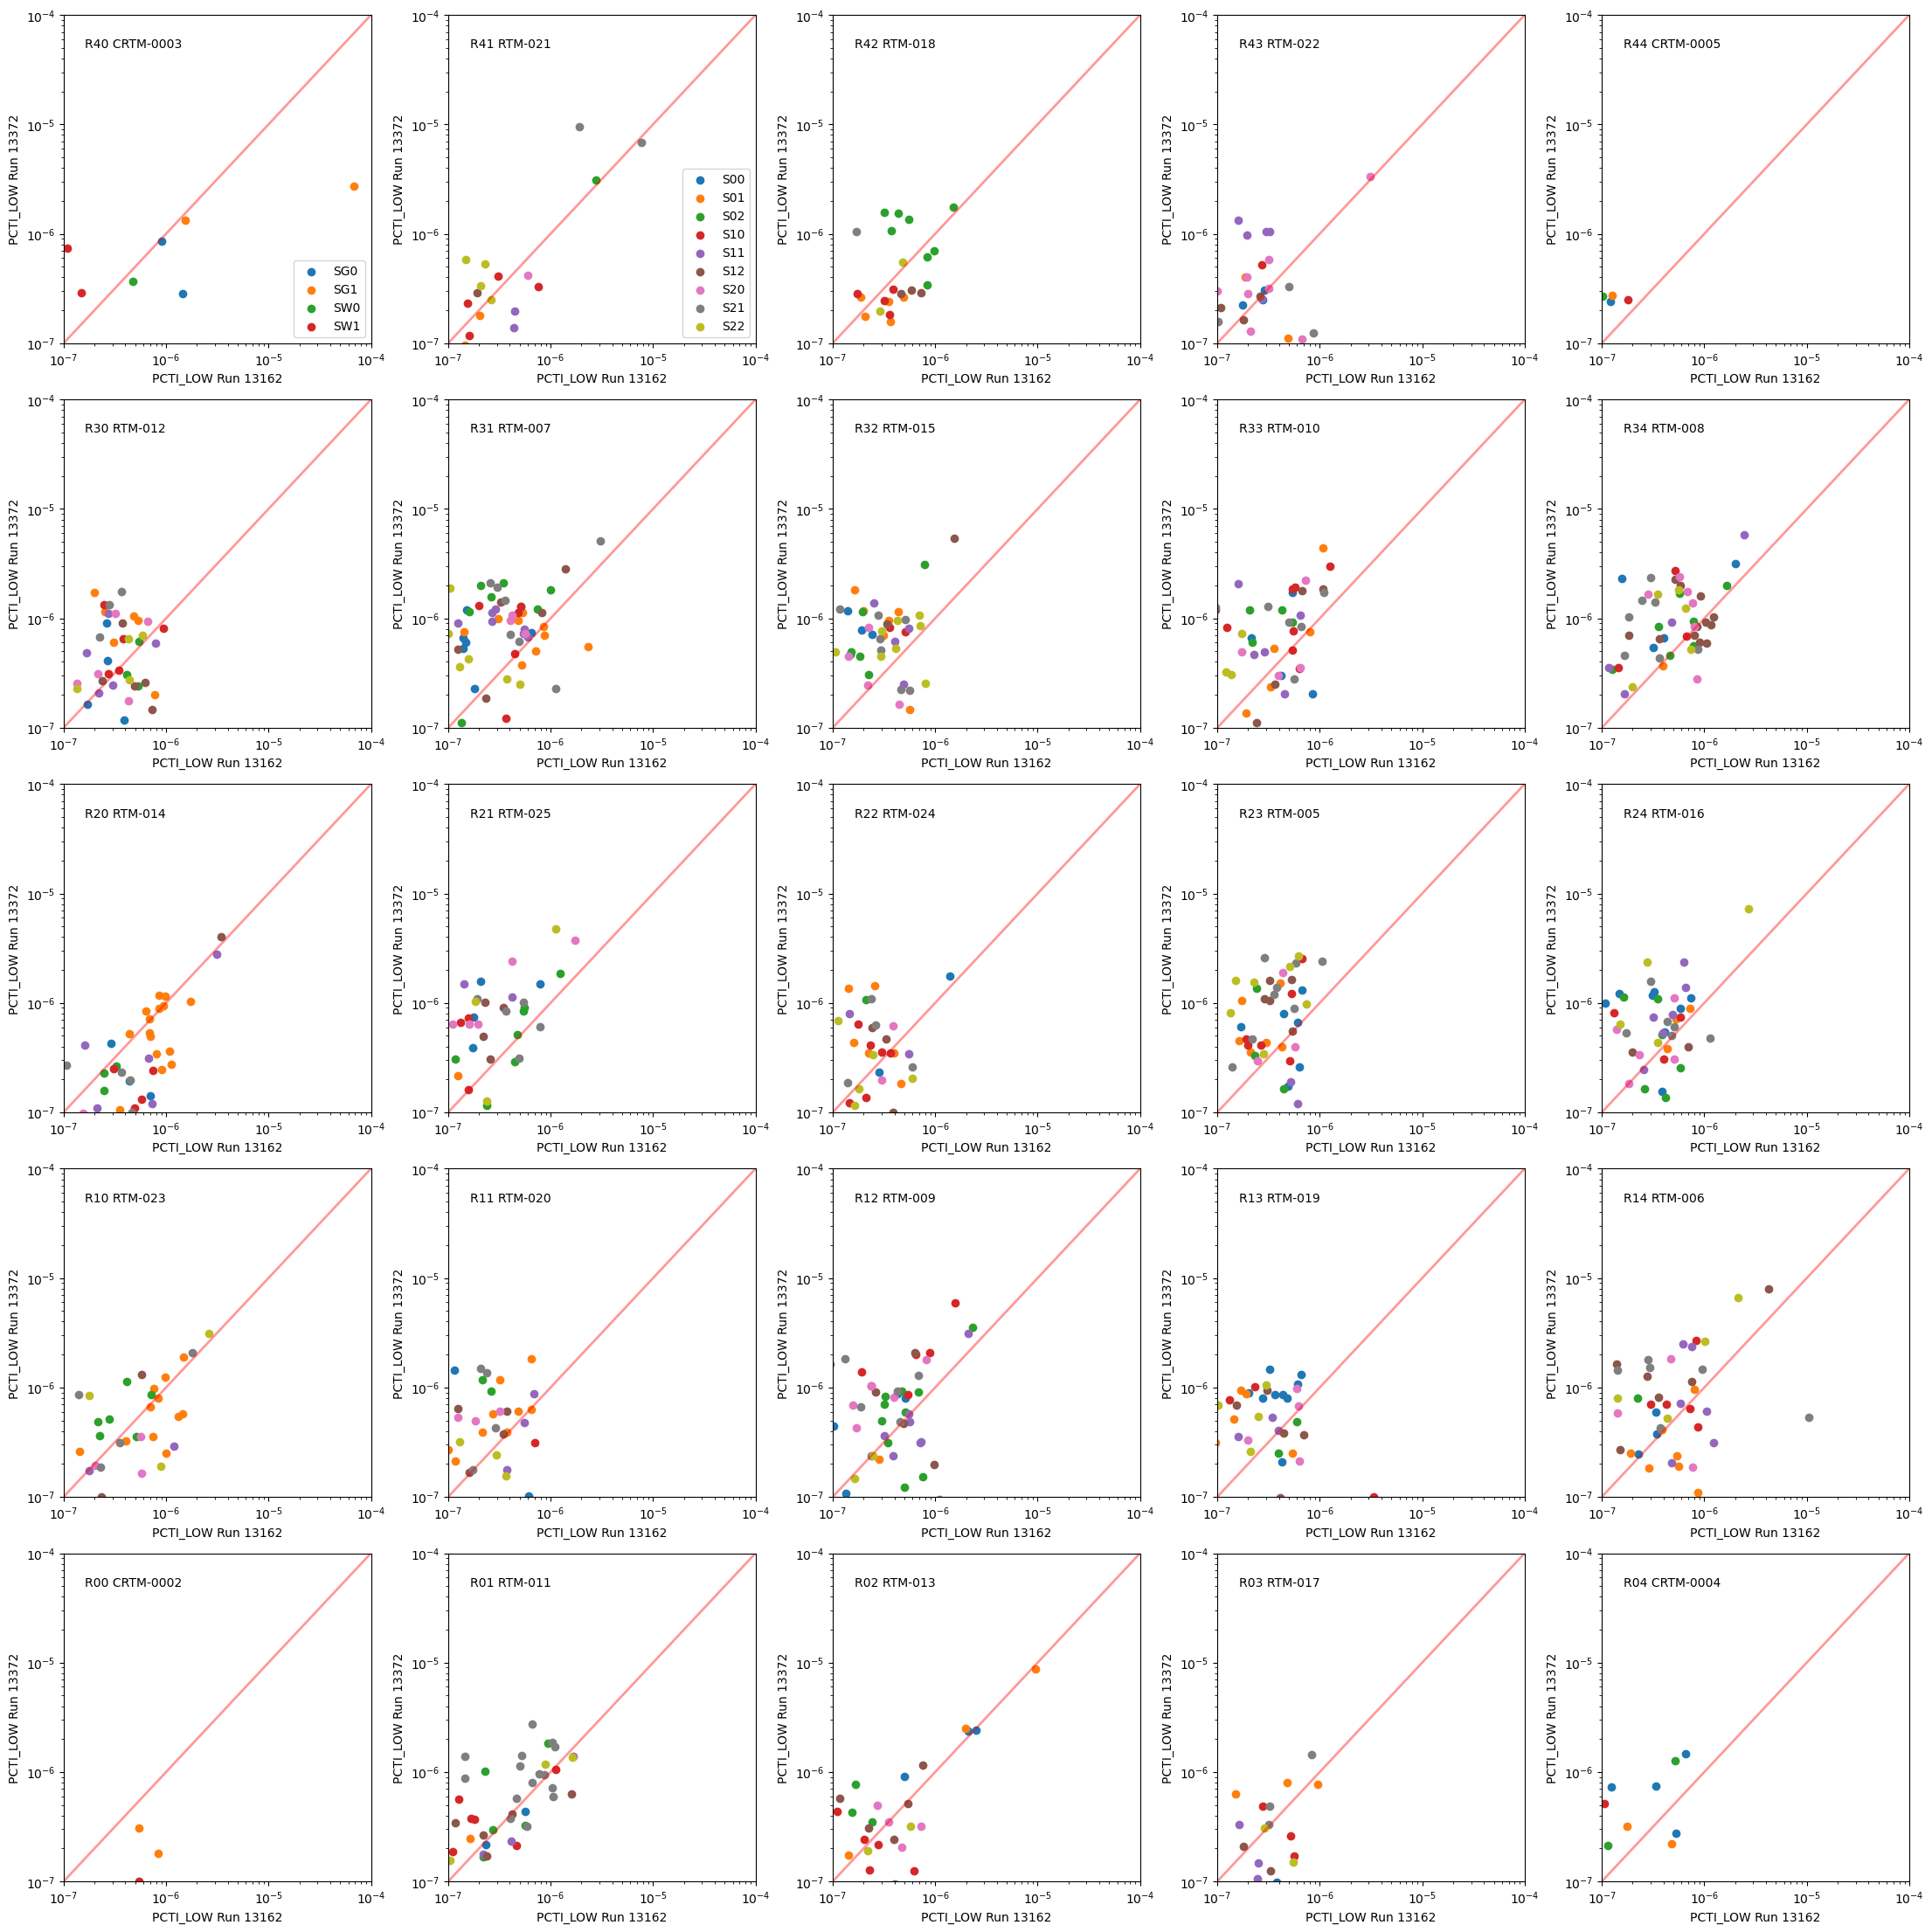

In [28]:
compare_tworuns(df_run5,df_data,'13162','13372',quantity='PCTI_LOW',minxy=1.e-7,maxxy=1.e-4,scale='log',save='pcti_low_%s'%(acq_run))

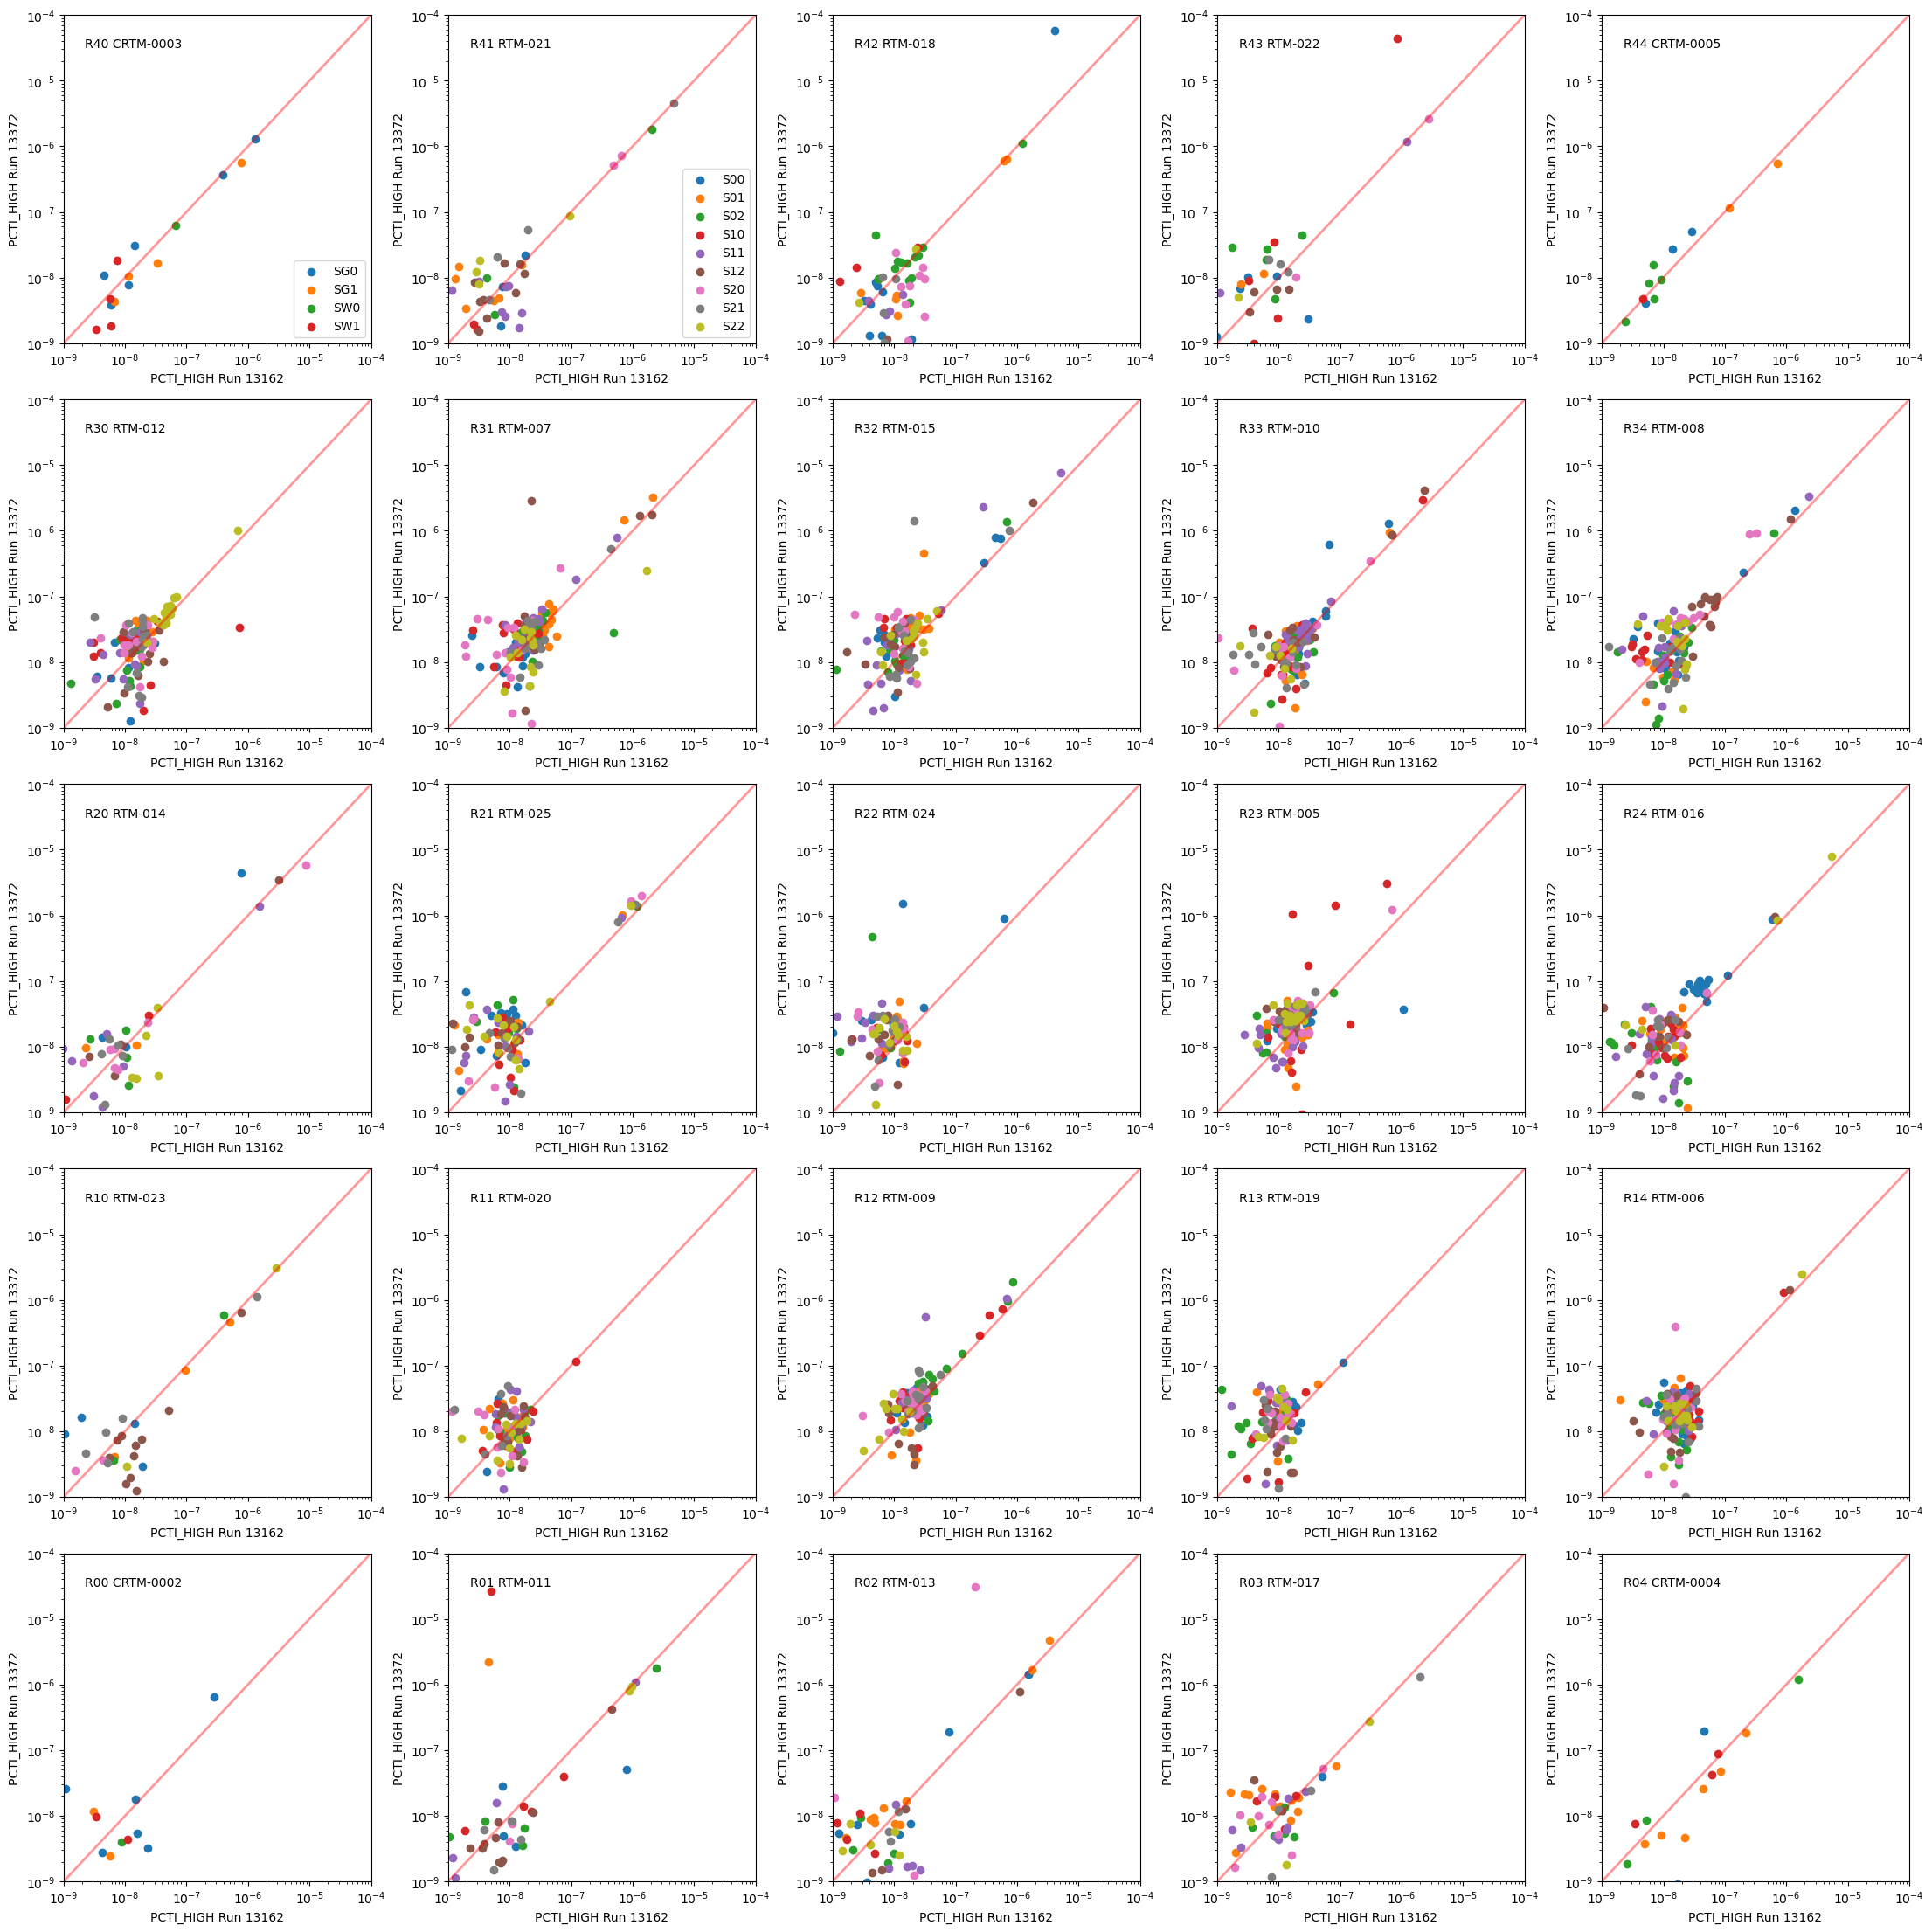

In [29]:
compare_tworuns(df_run5,df_data,'13162','13372',quantity='PCTI_HIGH',minxy=1.e-9,maxxy=1.e-4,scale='log',save='pcti_high_%s'%(acq_run))

# Divisidero

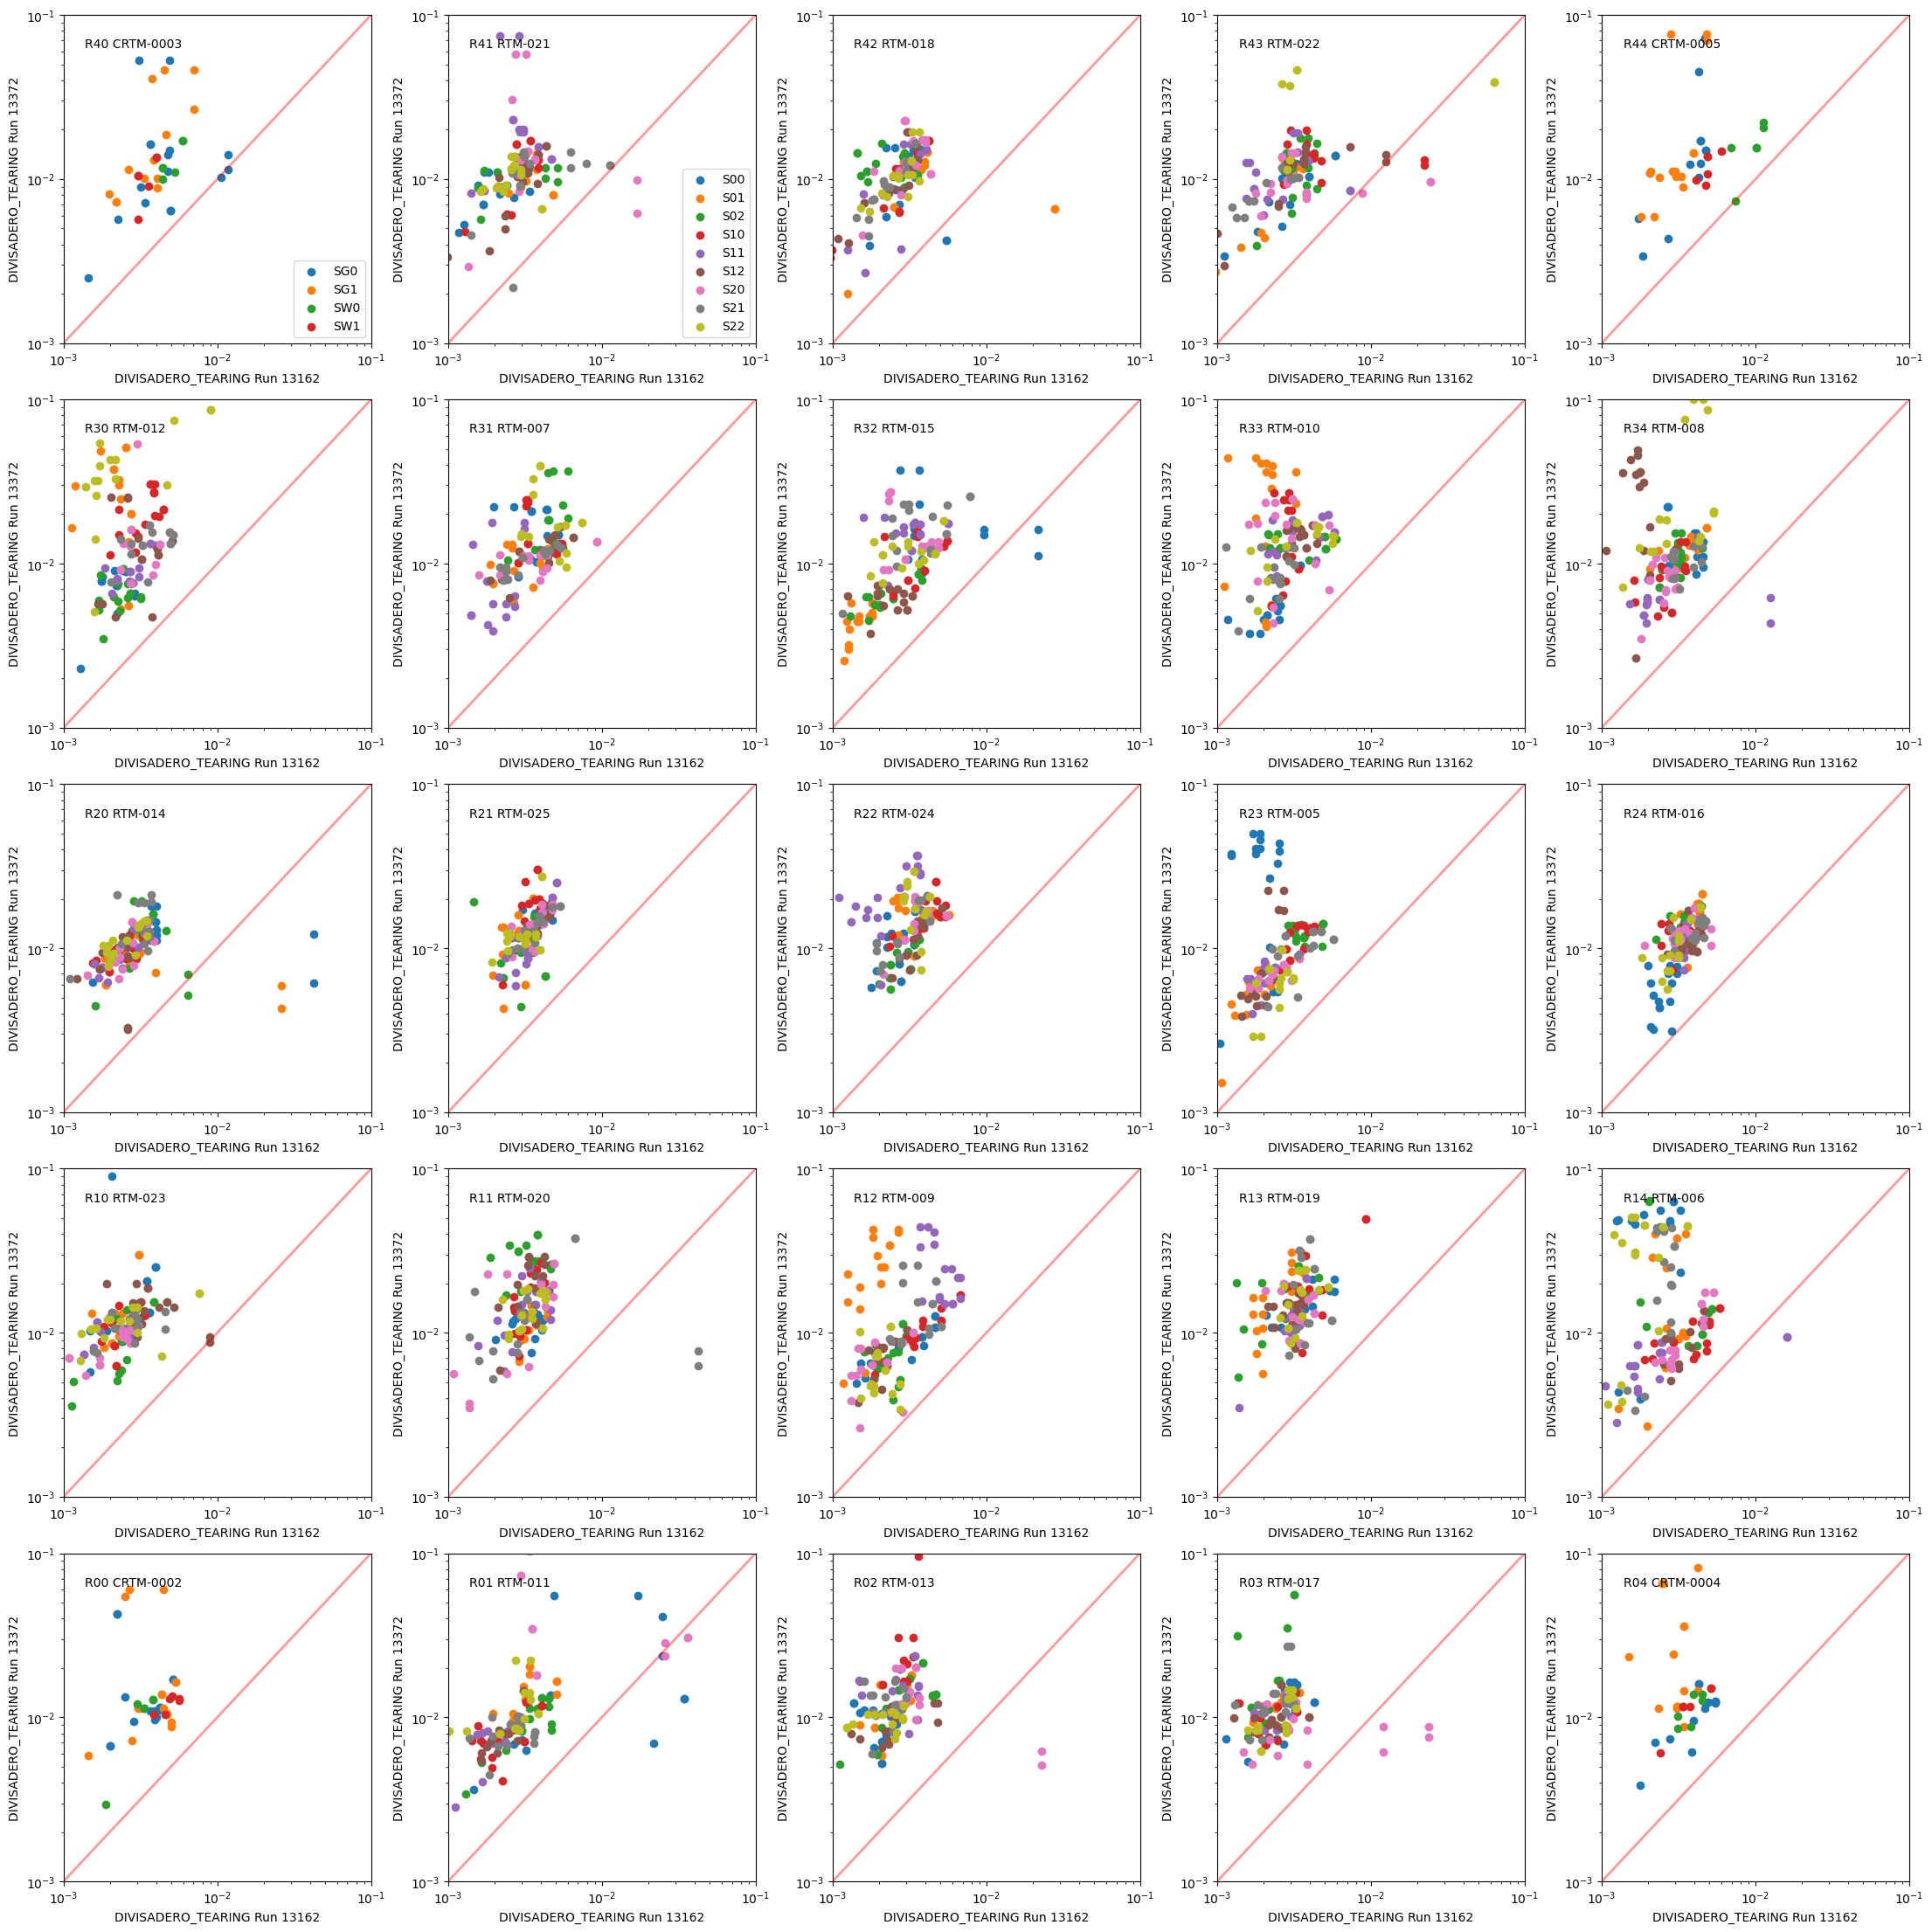

In [30]:
compare_tworuns(df_run5,df_data,'13162','13372',quantity='DIVISADERO_TEARING',minxy=1.e-3,maxxy=1.e-1,scale='log',save='divisadero_tearing_%s'%(acq_run))

# Dark Current

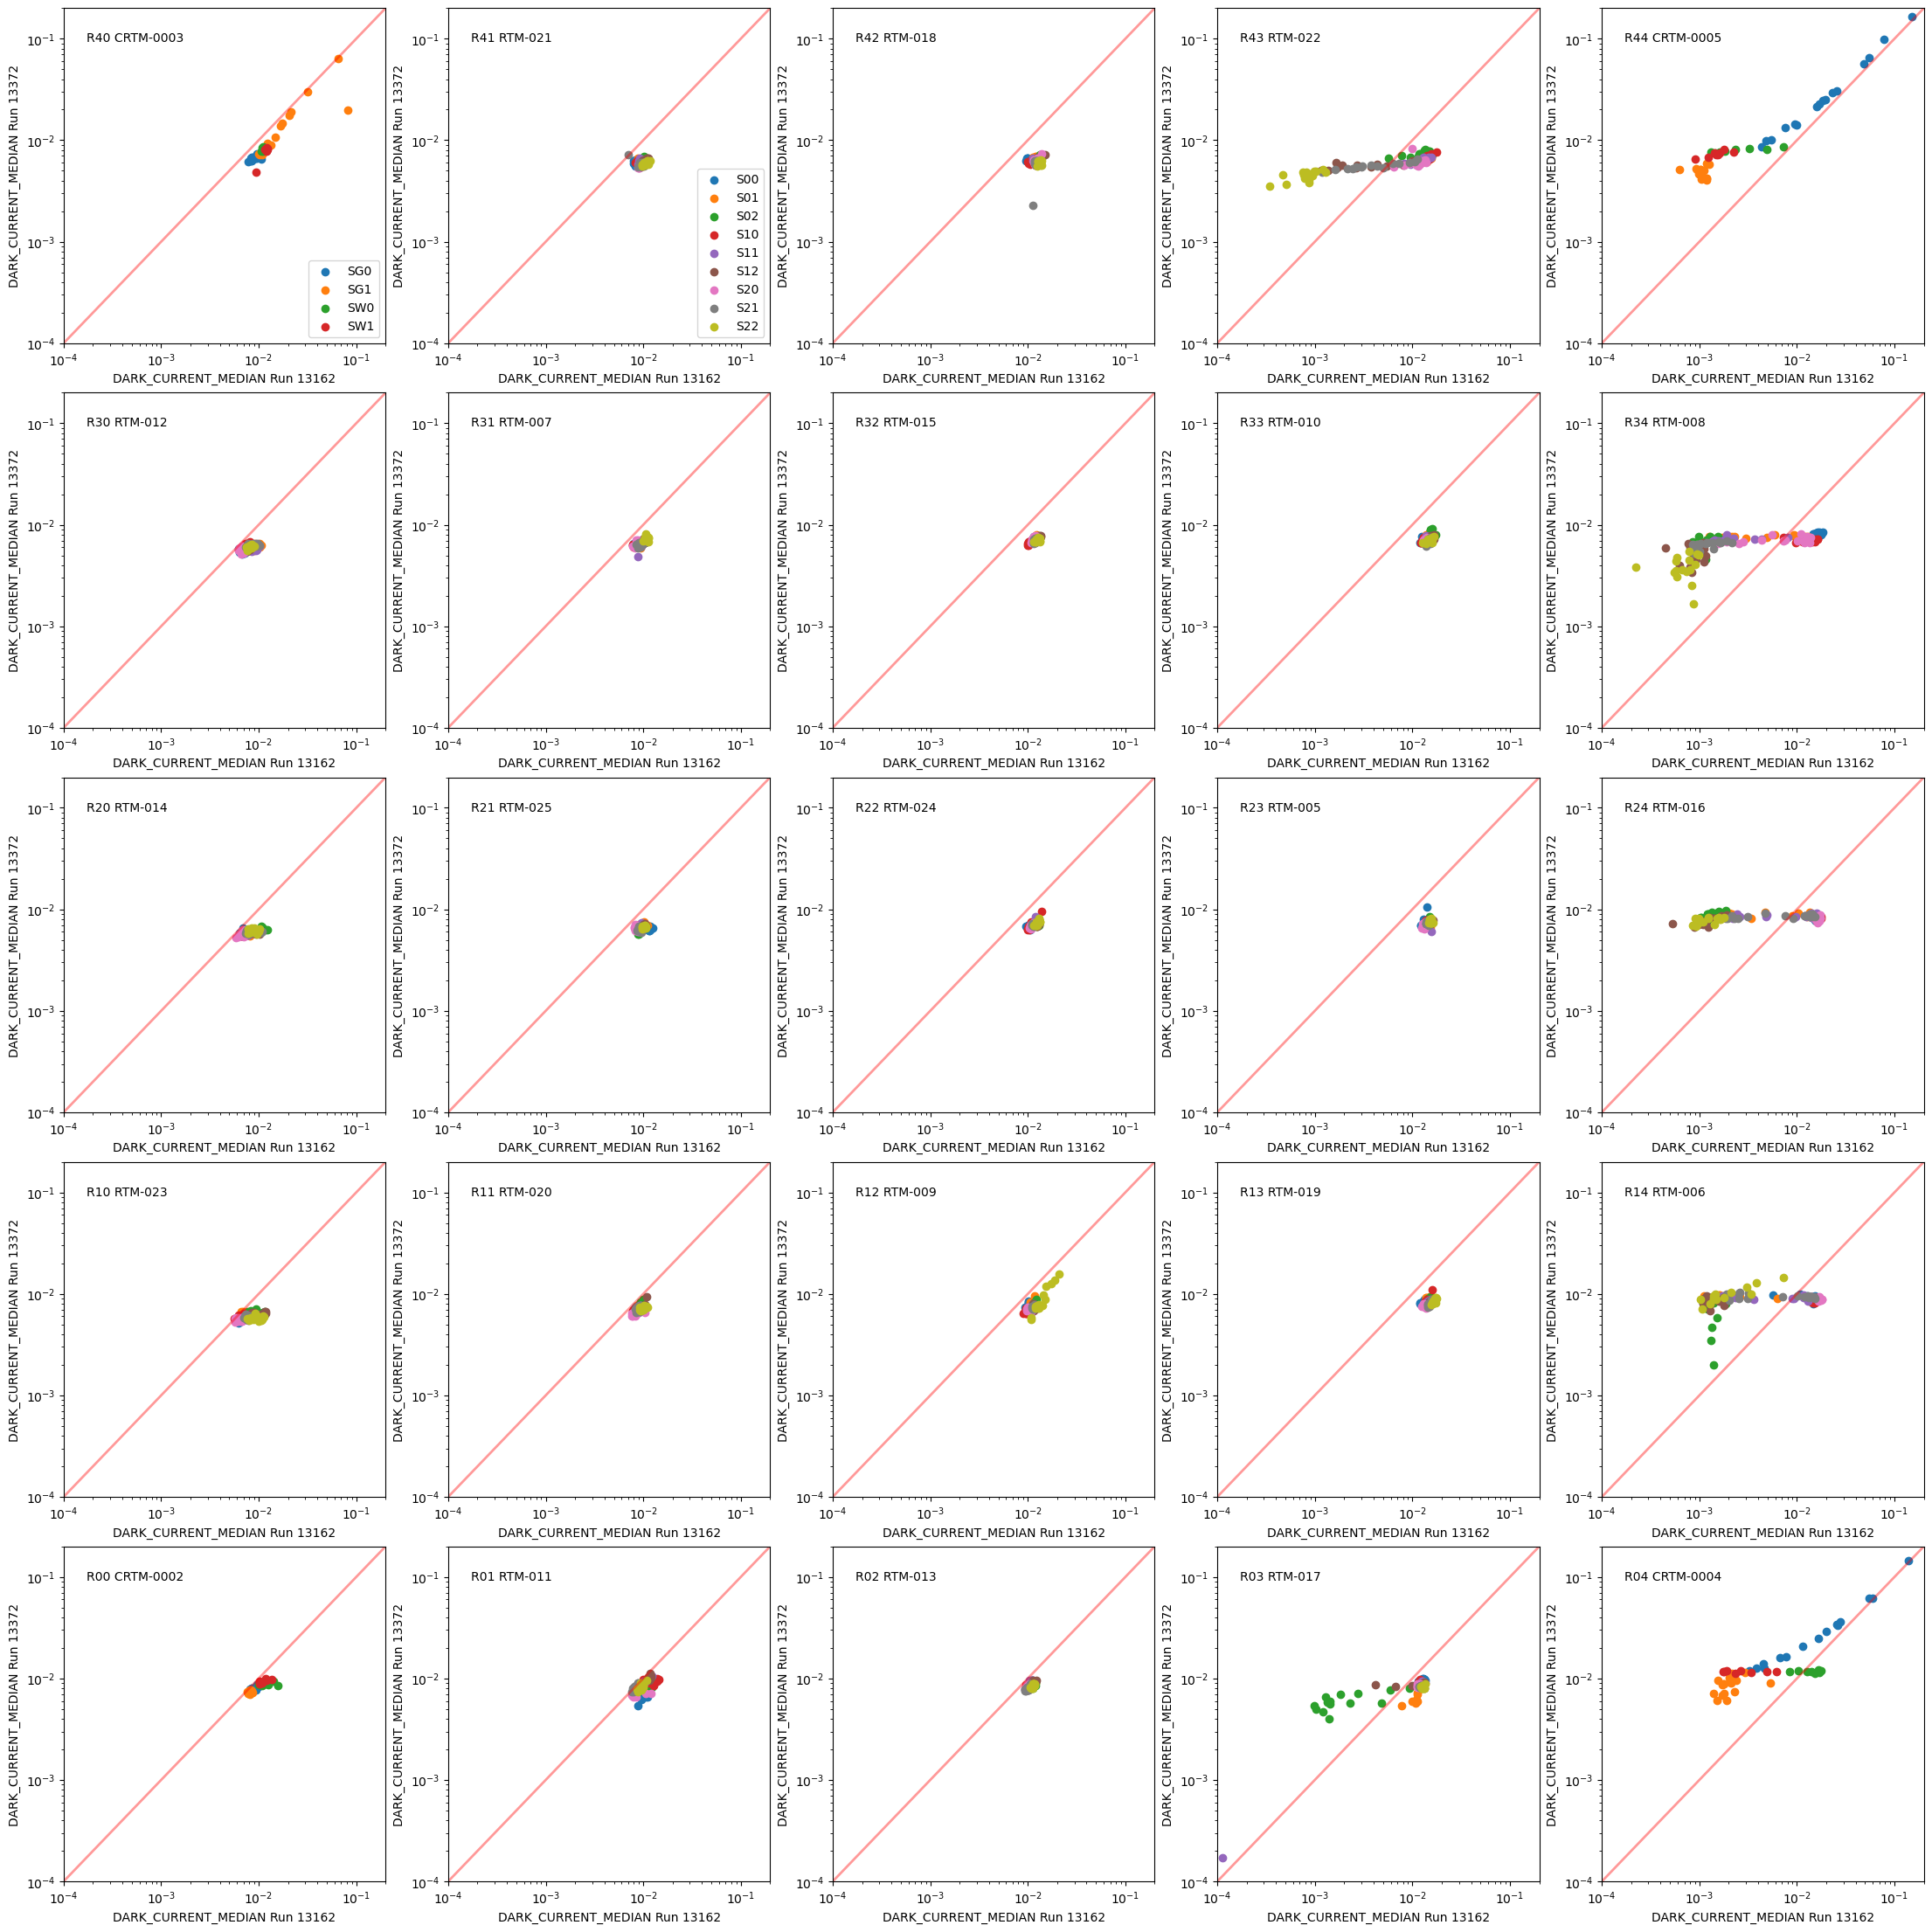

In [33]:
compare_tworuns(df_run5,df_data,'13162','13372',quantity='DARK_CURRENT_MEDIAN',minxy=1.e-4,maxxy=2.e-1,scale='log',save='darkcurrent_median_%s'%(acq_run))

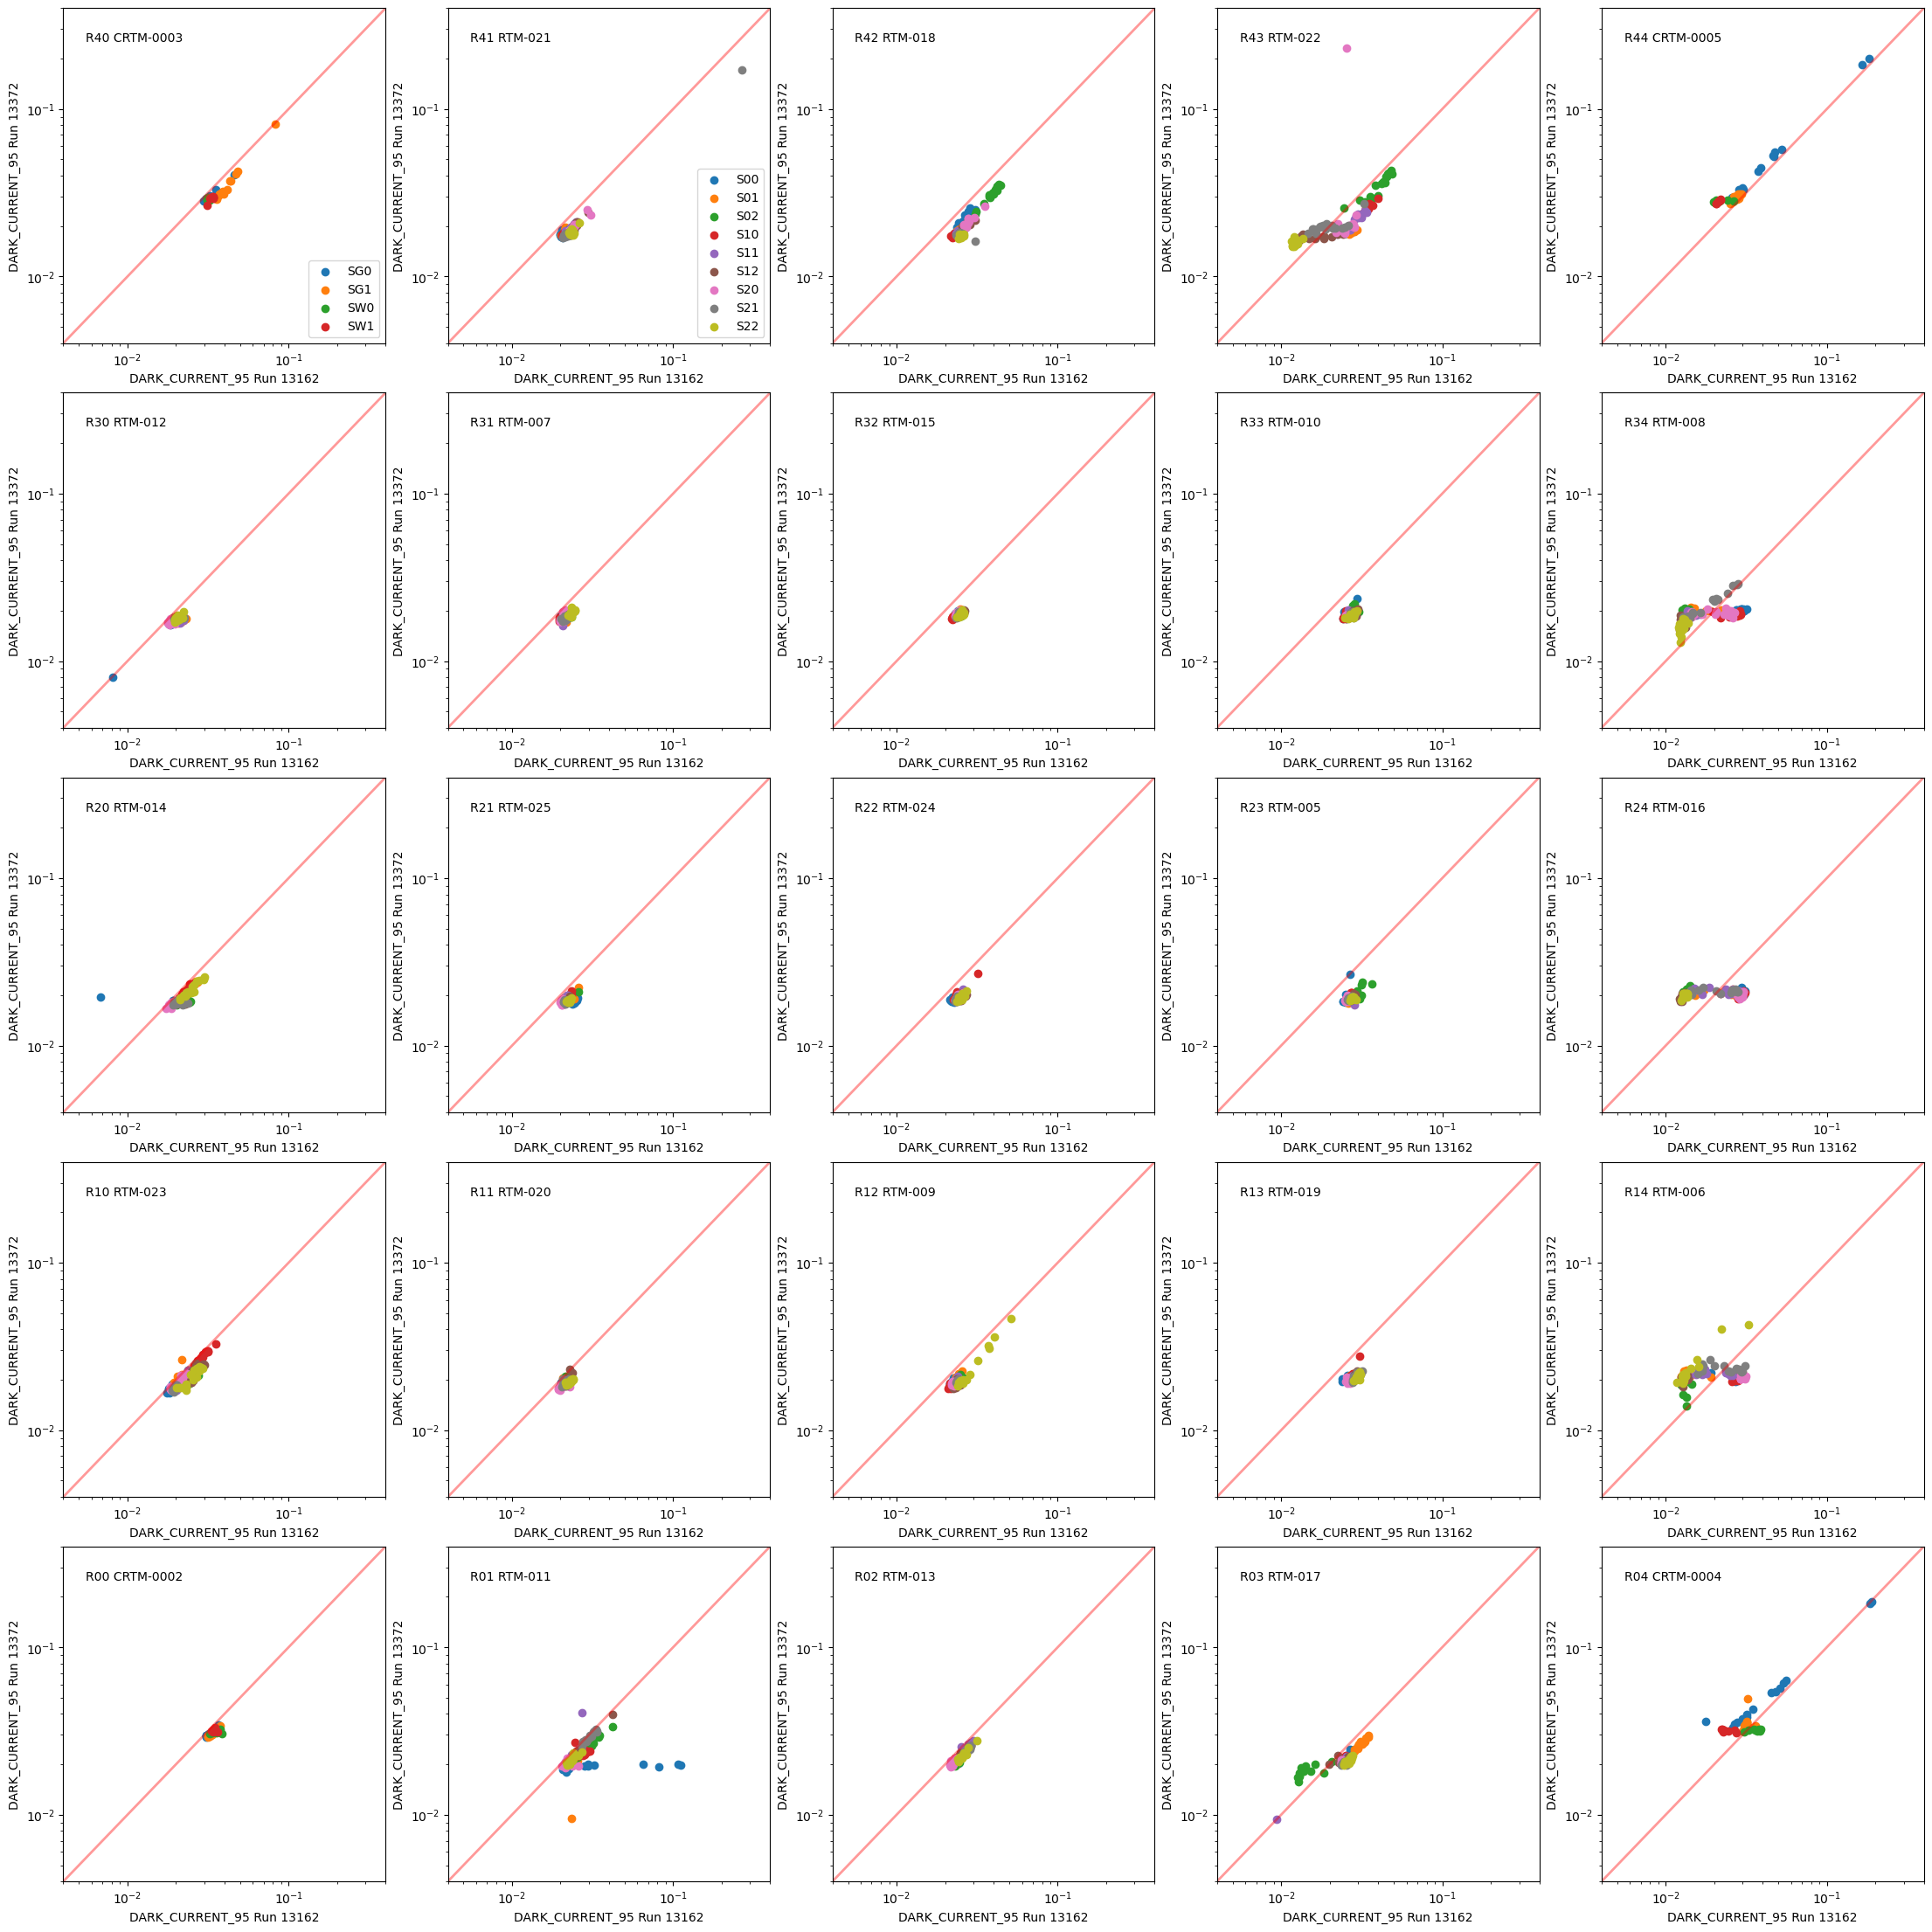

In [35]:
compare_tworuns(df_run5,df_data,'13162','13372',quantity='DARK_CURRENT_95',minxy=4.e-3,maxxy=4.e-1,scale='log',save='darkcurrent_95_%s'%(acq_run))

## High Dark Current channels

In [39]:
highdarkcurrent = (df_merge.DARK_CURRENT_MEDIAN>0.1)
print(tabulate(df_merge[highdarkcurrent][['BAY_SLOT','SEGMENT','DARK_CURRENT_MEDIAN','DARK_CURRENT_95','DARK_CURRENT_MEDIAN_RUN5','DARK_CURRENT_95_RUN5','COMMENT']],headers='keys',tablefmt='psql'))

+------+------------+-----------+-----------------------+-------------------+----------------------------+------------------------+-----------+
|      | BAY_SLOT   | SEGMENT   |   DARK_CURRENT_MEDIAN |   DARK_CURRENT_95 |   DARK_CURRENT_MEDIAN_RUN5 |   DARK_CURRENT_95_RUN5 | COMMENT   |
|------+------------+-----------+-----------------------+-------------------+----------------------------+------------------------+-----------|
|  482 | R04_SG0    | C12       |               0.14378 |           1.72076 |                   0.139878 |                1.77112 | Ok        |
| 3180 | R44_SG0    | C03       |               0.16404 |           1.82794 |                   0.150438 |                1.72514 | Ok        |
+------+------------+-----------+-----------------------+-------------------+----------------------------+------------------------+-----------+


## Dark Current Mosiac

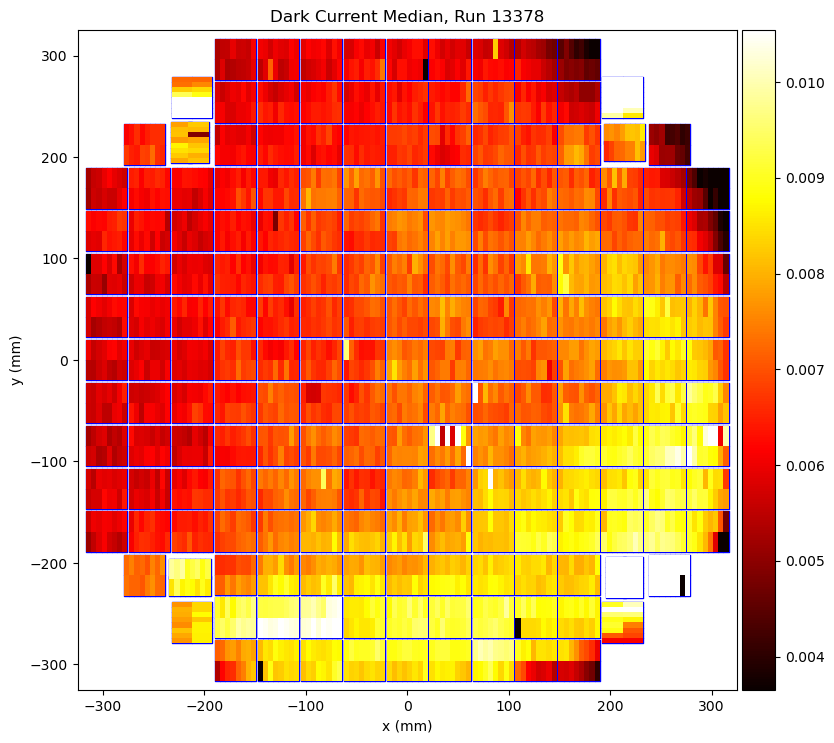

In [48]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, amp_data['dark_current_median'], use_log10=False, nsigma=3, z_range='clipped_autoscale')
ax.set_title('Dark Current Median, Run %s'%(acq_run))
f.savefig('darkcurrent_median_mosaic_%s'%(acq_run))

## Run5 Dark Current Median for comparison

In [46]:
import pickle
amp_data_run5 = pickle.load(open('amp_data_13144_13162_w_2023_22.pkl','rb'))

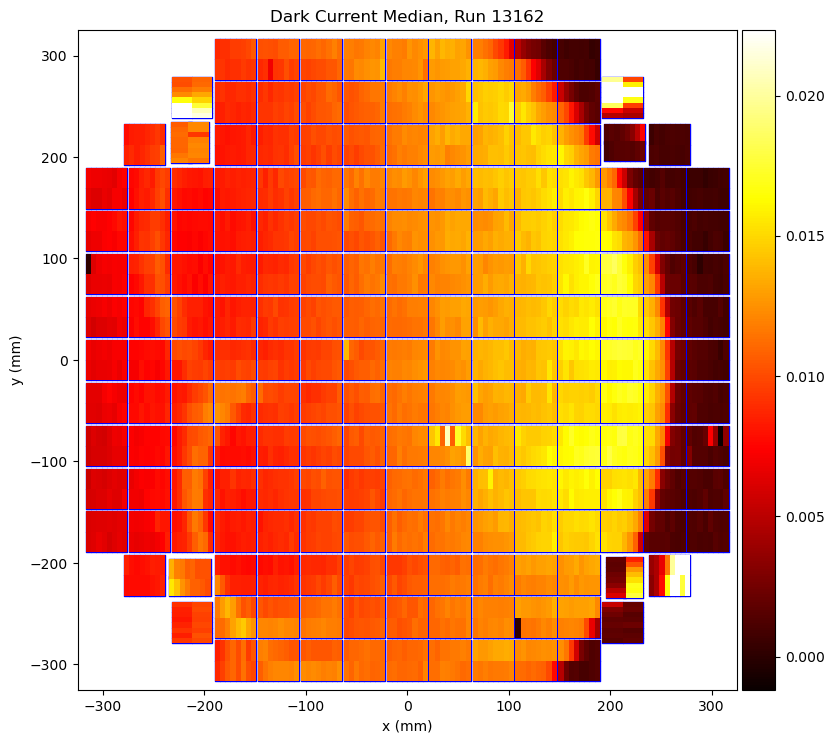

In [49]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, amp_data_run5['dark_current_median'], use_log10=False, nsigma=3, z_range='clipped_autoscale')
ax.set_title('Dark Current Median, Run %s'%('13162'))
f.savefig('darkcurrent_median_mosaic_%s'%('13162'))

### Ah - there was a known light leak from the flat illuminator light source in Run5 BOT data

# Bias Stability

In [50]:
butler_collections = daf_butler.Butler(repo, collections=collections)
biasstab = {}
for i in range(205):
    biasstab[i] = butler_collections.get('bias_stability_stats',detector=i)

In [51]:
biasstab[98].columns

Index(['run', 'exposure_id', 'mjd', 'det_name', 'amp_name', 'mean', 'stdev',
       'rc_mean', 'rc_stdev'],
      dtype='object')

In [52]:
df_98 = biasstab[98]
print(tabulate(df_98[(df_98.amp_name=='C10')],headers = 'keys', tablefmt = 'psql',floatfmt='0.3f'))
print(len(df_98[(df_98.amp_name=='C10')]))

+-----+-------+---------------+-----------+------------+------------+--------+---------+-----------+------------+
|     |   run |   exposure_id |       mjd | det_name   | amp_name   |   mean |   stdev |   rc_mean |   rc_stdev |
|-----+-------+---------------+-----------+------------+------------+--------+---------+-----------+------------|
|   0 | 13378 | 3023061900224 | 60115.035 | R22_S22    | C10        |  0.179 |   3.519 |     0.333 |      3.545 |
|  16 | 13378 | 3023061900242 | 60115.039 | R22_S22    | C10        |  0.241 |   3.541 |     0.492 |      3.566 |
|  32 | 13378 | 3023061900262 | 60115.041 | R22_S22    | C10        |  0.215 |   3.533 |     0.348 |      3.558 |
|  48 | 13378 | 3023061900160 | 60114.996 | R22_S22    | C10        |  0.091 |   3.539 |     0.330 |      3.563 |
|  64 | 13378 | 3023061900212 | 60115.033 | R22_S22    | C10        |  0.287 |   3.526 |     0.414 |      3.548 |
|  80 | 13378 | 3023061900257 | 60115.040 | R22_S22    | C10        |  0.263 |   3.542 |

## Calculate bias stability RMS for all and rc

In [53]:
df_bias = calc_biasstability_rms(biasstab)

In [54]:
e2v = (df_bias.TYPE=='e2v')
itl = (df_bias.TYPE=='itl') 
corner = (df_bias.TYPE=='corner')

In [55]:
print(df_bias)

     BAY_SLOT    TYPE SEGMENT       RMS    RC_RMS
0     R01_S00     itl     C10  0.055487  0.075958
1     R01_S00     itl     C11  0.023084  0.046265
2     R01_S00     itl     C12  0.039017  0.061387
3     R01_S00     itl     C13  0.035802  0.067406
4     R01_S00     itl     C14  0.090154  0.057830
...       ...     ...     ...       ...       ...
3211  R44_SW1  corner     C13  0.025995  0.067240
3212  R44_SW1  corner     C14  0.025568  0.073208
3213  R44_SW1  corner     C15  0.038465  0.064830
3214  R44_SW1  corner     C16  0.024635  0.078003
3215  R44_SW1  corner     C17  0.026997  0.070375

[3216 rows x 5 columns]


Text(0.5, 0.98, 'Run 13378')

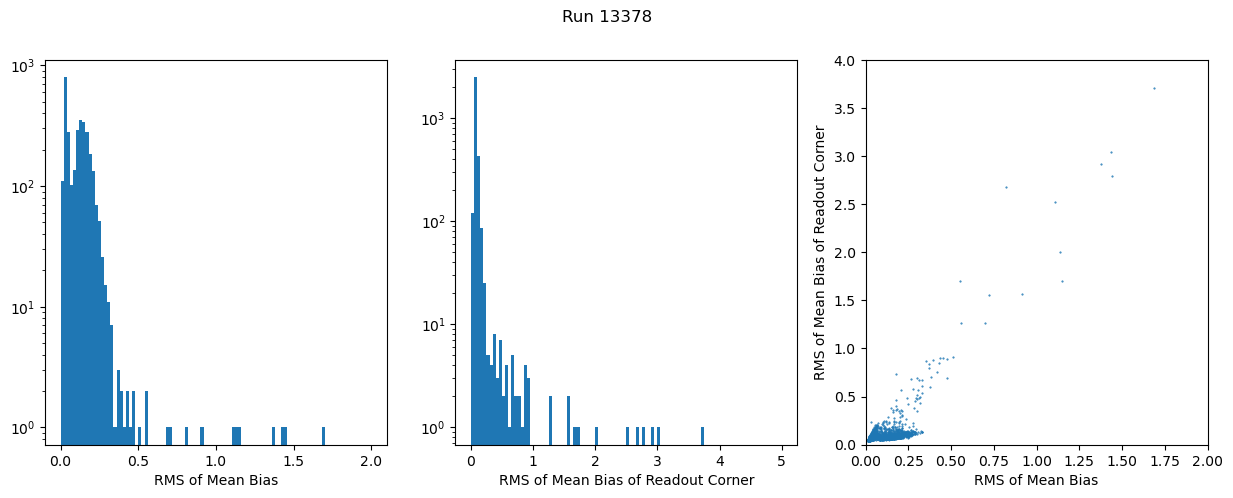

In [56]:
f,ax = plt.subplots(1,3,figsize=(15,5))
h = ax[0].hist(df_bias.RMS,bins=100,range=(0.,2.))
ax[0].set_xlabel('RMS of Mean Bias')
ax[0].set_yscale('log')

h = ax[1].hist(df_bias.RC_RMS,bins=100,range=(0.,5.))
ax[1].set_xlabel('RMS of Mean Bias of Readout Corner')
ax[1].set_yscale('log')

h = ax[2].scatter(df_bias.RMS,df_bias.RC_RMS,marker='.',s=1.)
ax[2].set_ylim(0.,4.)
ax[2].set_xlim(0.,2.)
ax[2].set_xlabel('RMS of Mean Bias')
ax[2].set_ylabel('RMS of Mean Bias of Readout Corner')
f.suptitle('Run %s'%(acq_run))

In [57]:
# convert to amp_data format
def to_amp_data(df,name):
    
    outdict = {}
    for index, row in df.iterrows():
        if row.BAY_SLOT not in outdict:
            outdict[row.BAY_SLOT] = {}
            
        outdict[row.BAY_SLOT][row.SEGMENT] = row[name]
    return outdict

In [58]:
dict_rms = to_amp_data(df_bias,'RMS')
dict_rc_rms = to_amp_data(df_bias,'RC_RMS')

Text(0.5, 1.0, 'RMS of Mean Bias, Run 13378')

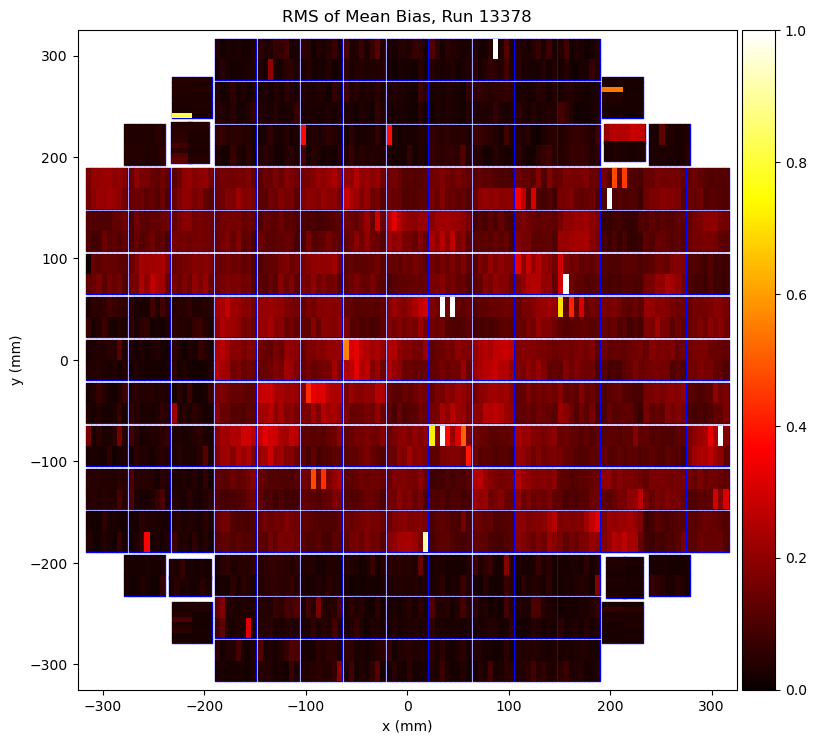

In [60]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, dict_rms, z_range=(0.,1.))
ax.set_title('RMS of Mean Bias, Run %s'%(acq_run))

Text(0.5, 1.0, 'RMS of Mean Bias in Readout Corner, Run 13378')

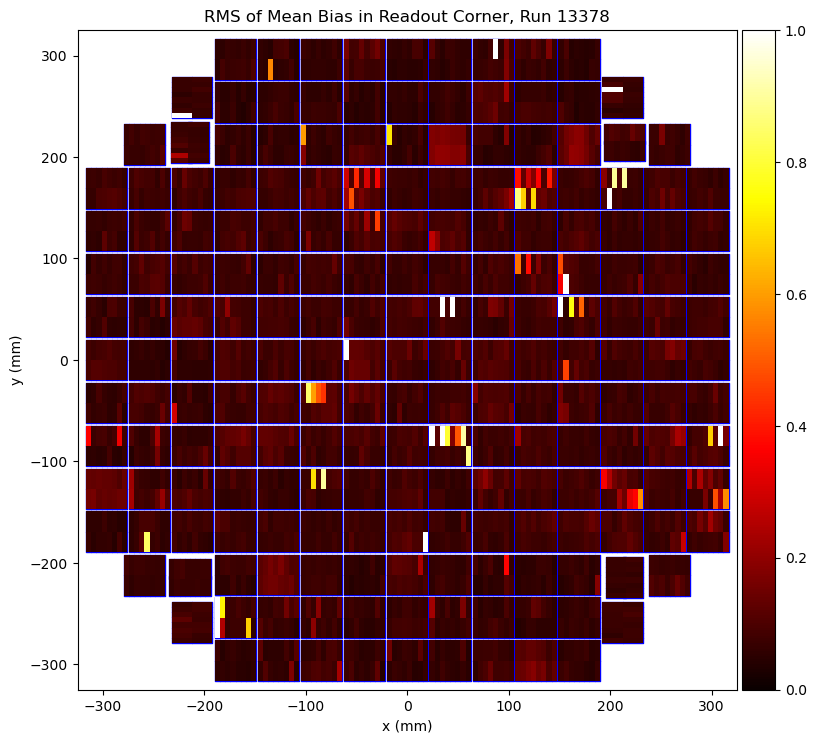

In [61]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, dict_rc_rms, z_range=(0, 1.))
ax.set_title('RMS of Mean Bias in Readout Corner, Run %s'%(acq_run))